# HW7 Time Series Analysis

In [4]:
### import module 

import pandas as pd
import xarray as xr
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Open and Check Data

In [5]:
### plot the data
df = pd.read_csv('../data/wtd1970_2018.csv', header=None)
print(df.shape)

(49, 2)


### 1. Plot the data with reversed y-axis

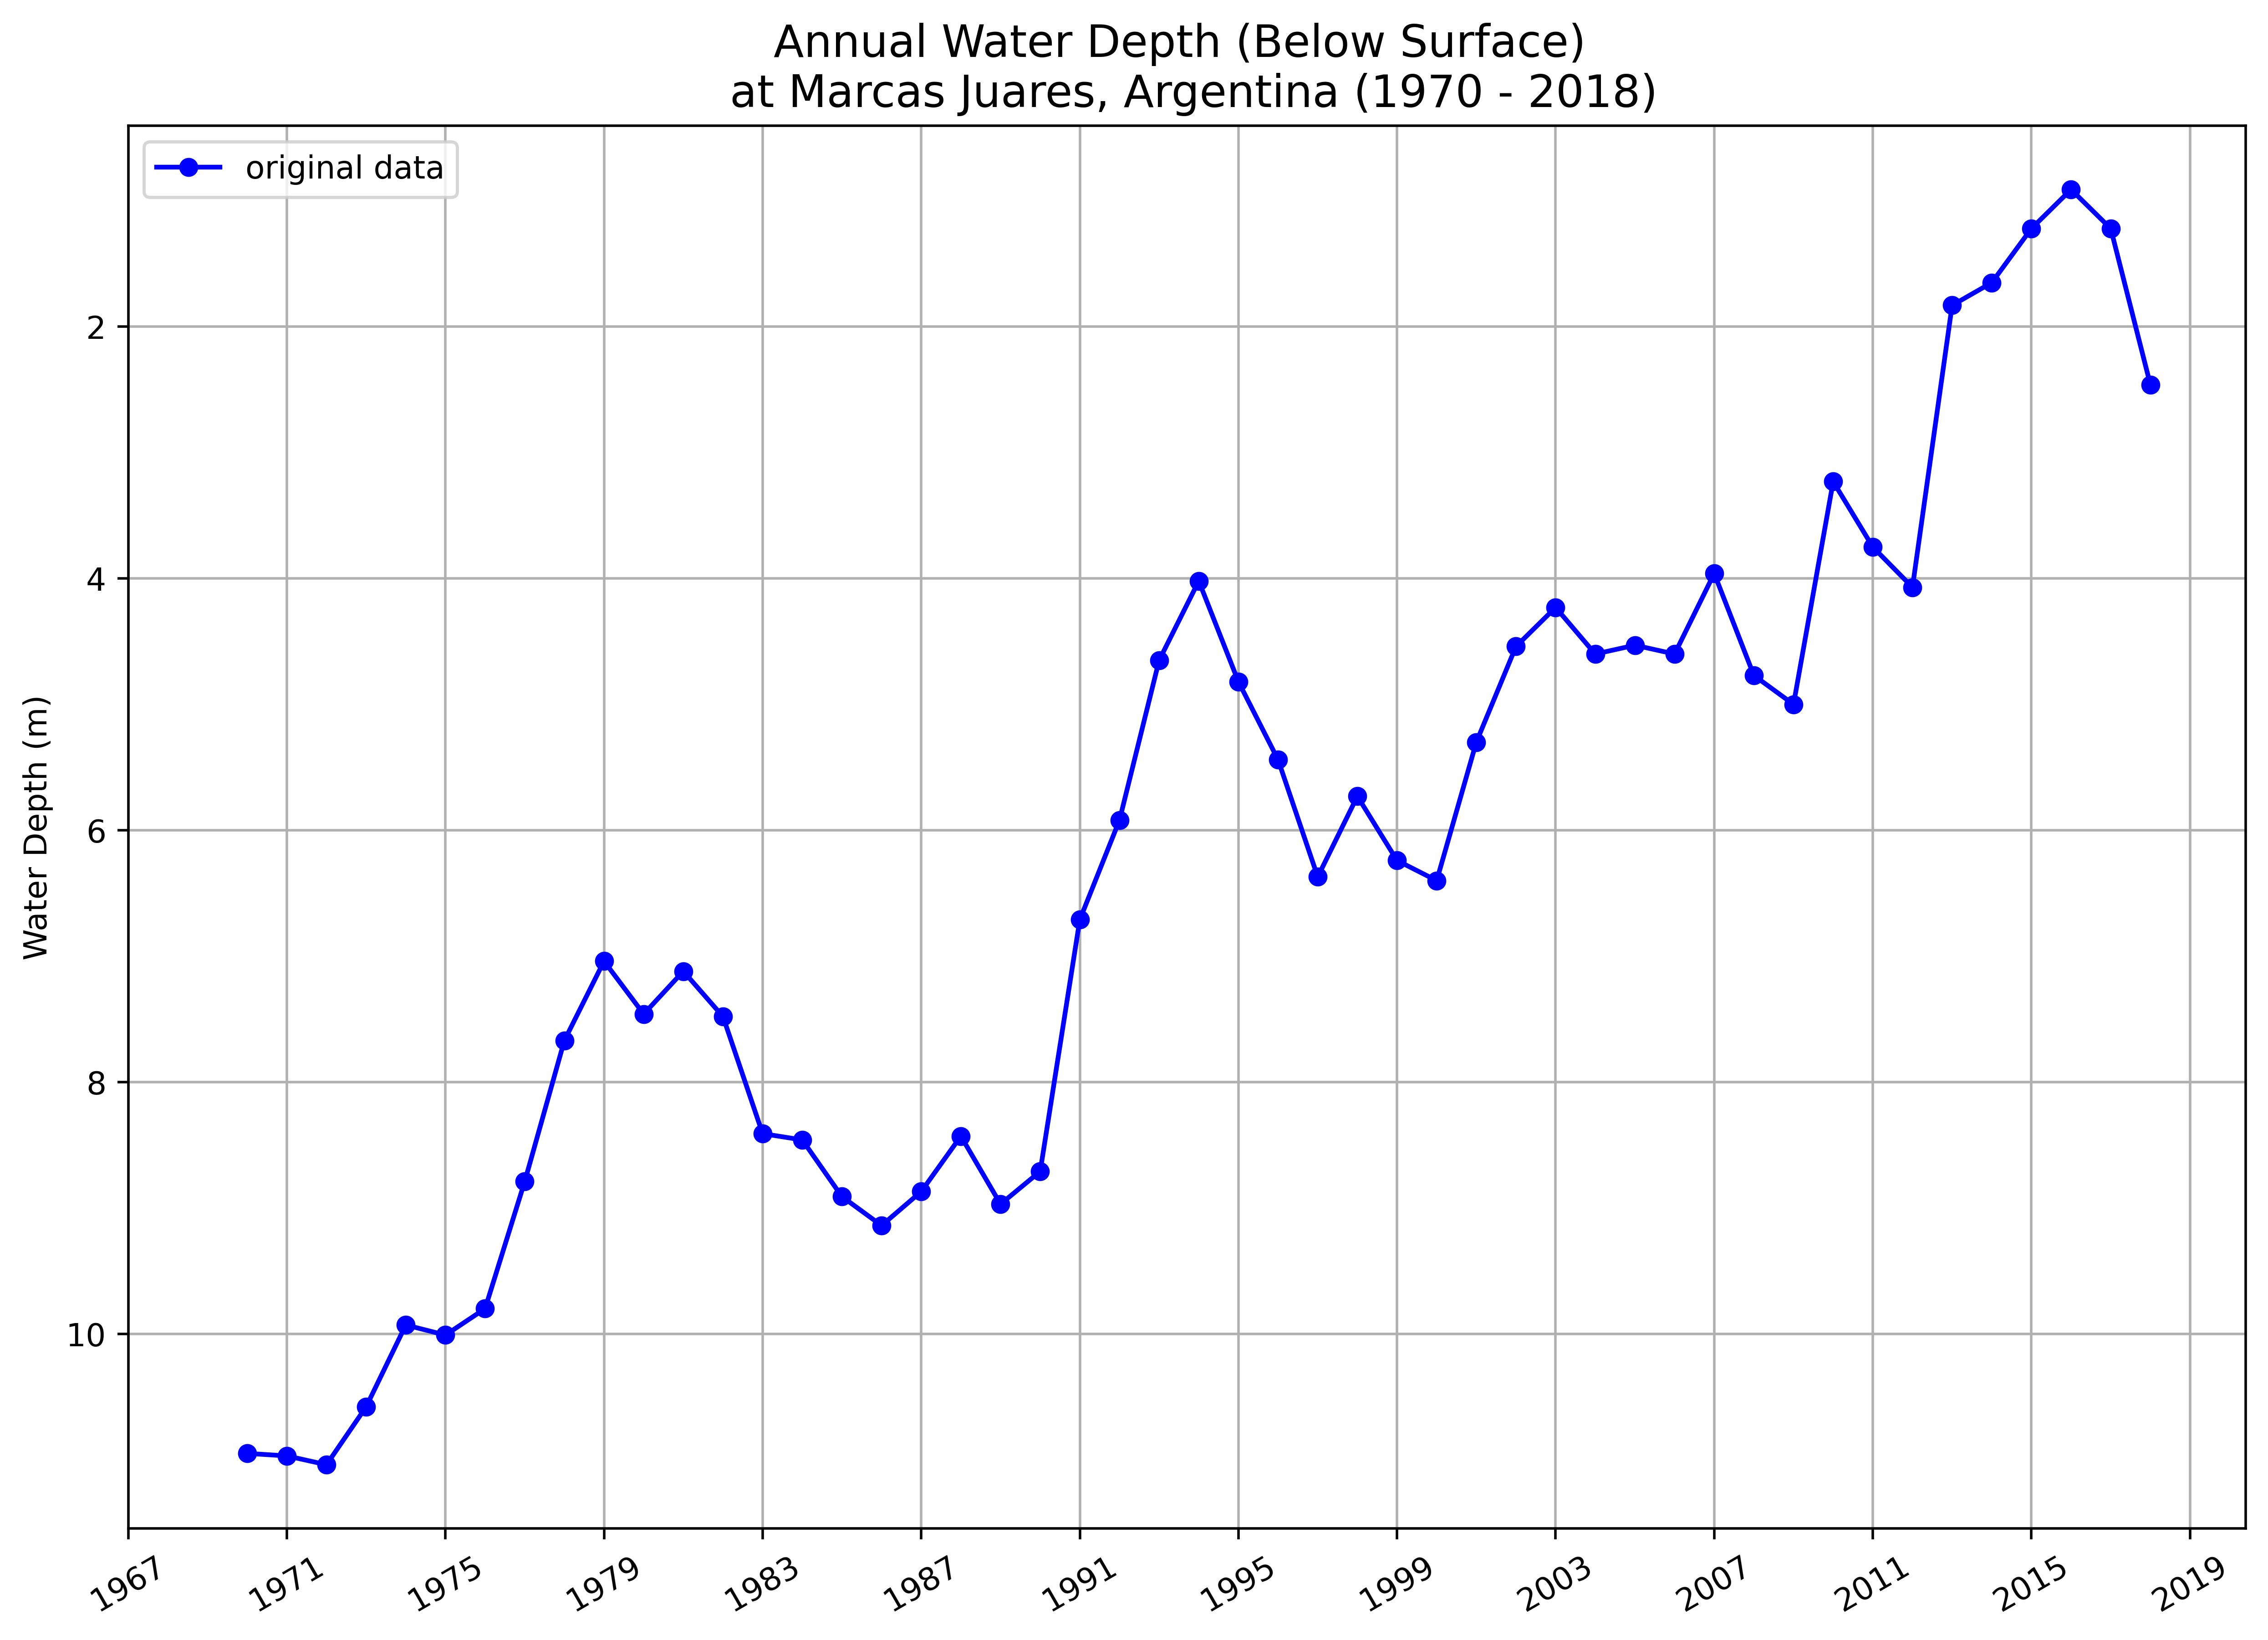

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=500)

ax.plot(df[0], df[1], color='b', marker='o', markersize=5, label='original data')
ax.set_title('Annual Water Depth (Below Surface) \n at Marcas Juares, Argentina (1970 - 2018)', fontsize=14)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start-0.6, end-0.4, 4))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
plt.xticks(rotation=30)
ax.invert_yaxis()
ax.grid(True)
ax.set_ylabel('Water Depth (m)')
ax.legend()


### 2. Fit a linear regression and plot it over the data

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     308.6
Date:                Mon, 04 Dec 2023   Prob (F-statistic):           2.75e-22
Time:                        13:23:56   Log-Likelihood:                -70.110
No. Observations:                  49   AIC:                             144.2
Df Residuals:                      47   BIC:                             148.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    371.8898     20.813     17.868      0.0

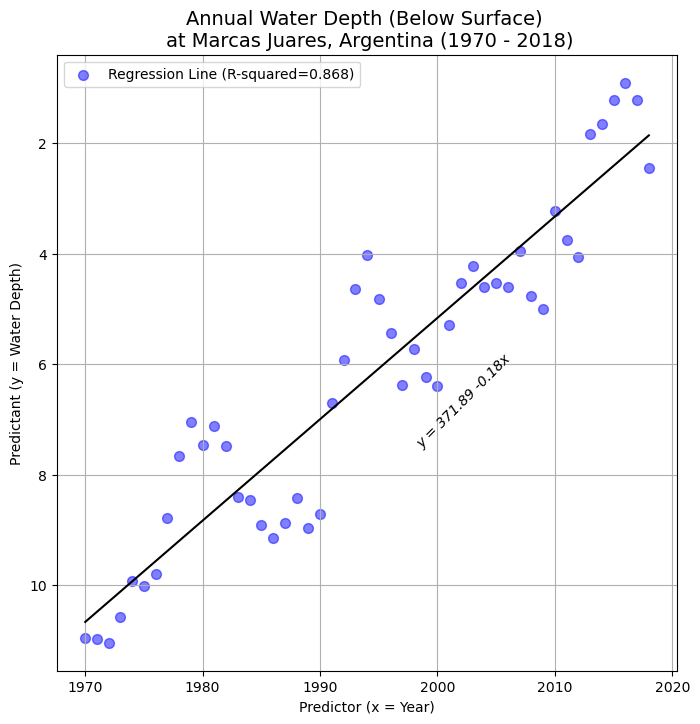

In [7]:
### perform stats model for single predictor
# import module
import statsmodels.api as sm
import statsmodels.formula.api as smf

# change variable to ease the calculation
X = df[0]
#print(X.shape)
Y = df[1]
#print(Y.shape)

# store the data into one dataframe
data = {'X': X,
        'Y': Y}
df_new = pd.DataFrame(data)

# perform stats model
model = smf.ols(formula='Y ~ X', data=df_new ).fit()
print(model.summary())

anova_table = sm.stats.anova_lm(model,typ=2)
print("\nANOVA Table:\n", anova_table)

# plot the data
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(X, Y, color='blue', marker='o', s=50, alpha=0.5, label=f'Regression Line (R-squared={model.rsquared:.3f})')
ax.set_title('Annual Water Depth (Below Surface) \n at Marcas Juares, Argentina (1970 - 2018)', fontsize=14)
ax.invert_yaxis()
ax.plot(X, model.params[0] + X*model.params[1], color='k')
ax.set_xlabel('Predictor (x = Year)')
ax.set_ylabel('Predictant (y = Water Depth)')

# add the model equation to the plot
equation = f'y = {model.params["Intercept"]:.2f} {model.params["X"]:.2f}x'
plt.text(1998, 7.5, equation, fontsize=10, color='k', fontstyle='italic', rotation=45)
ax.grid()
ax.legend()

### 3. Remove the linear trend and plot the normalized data

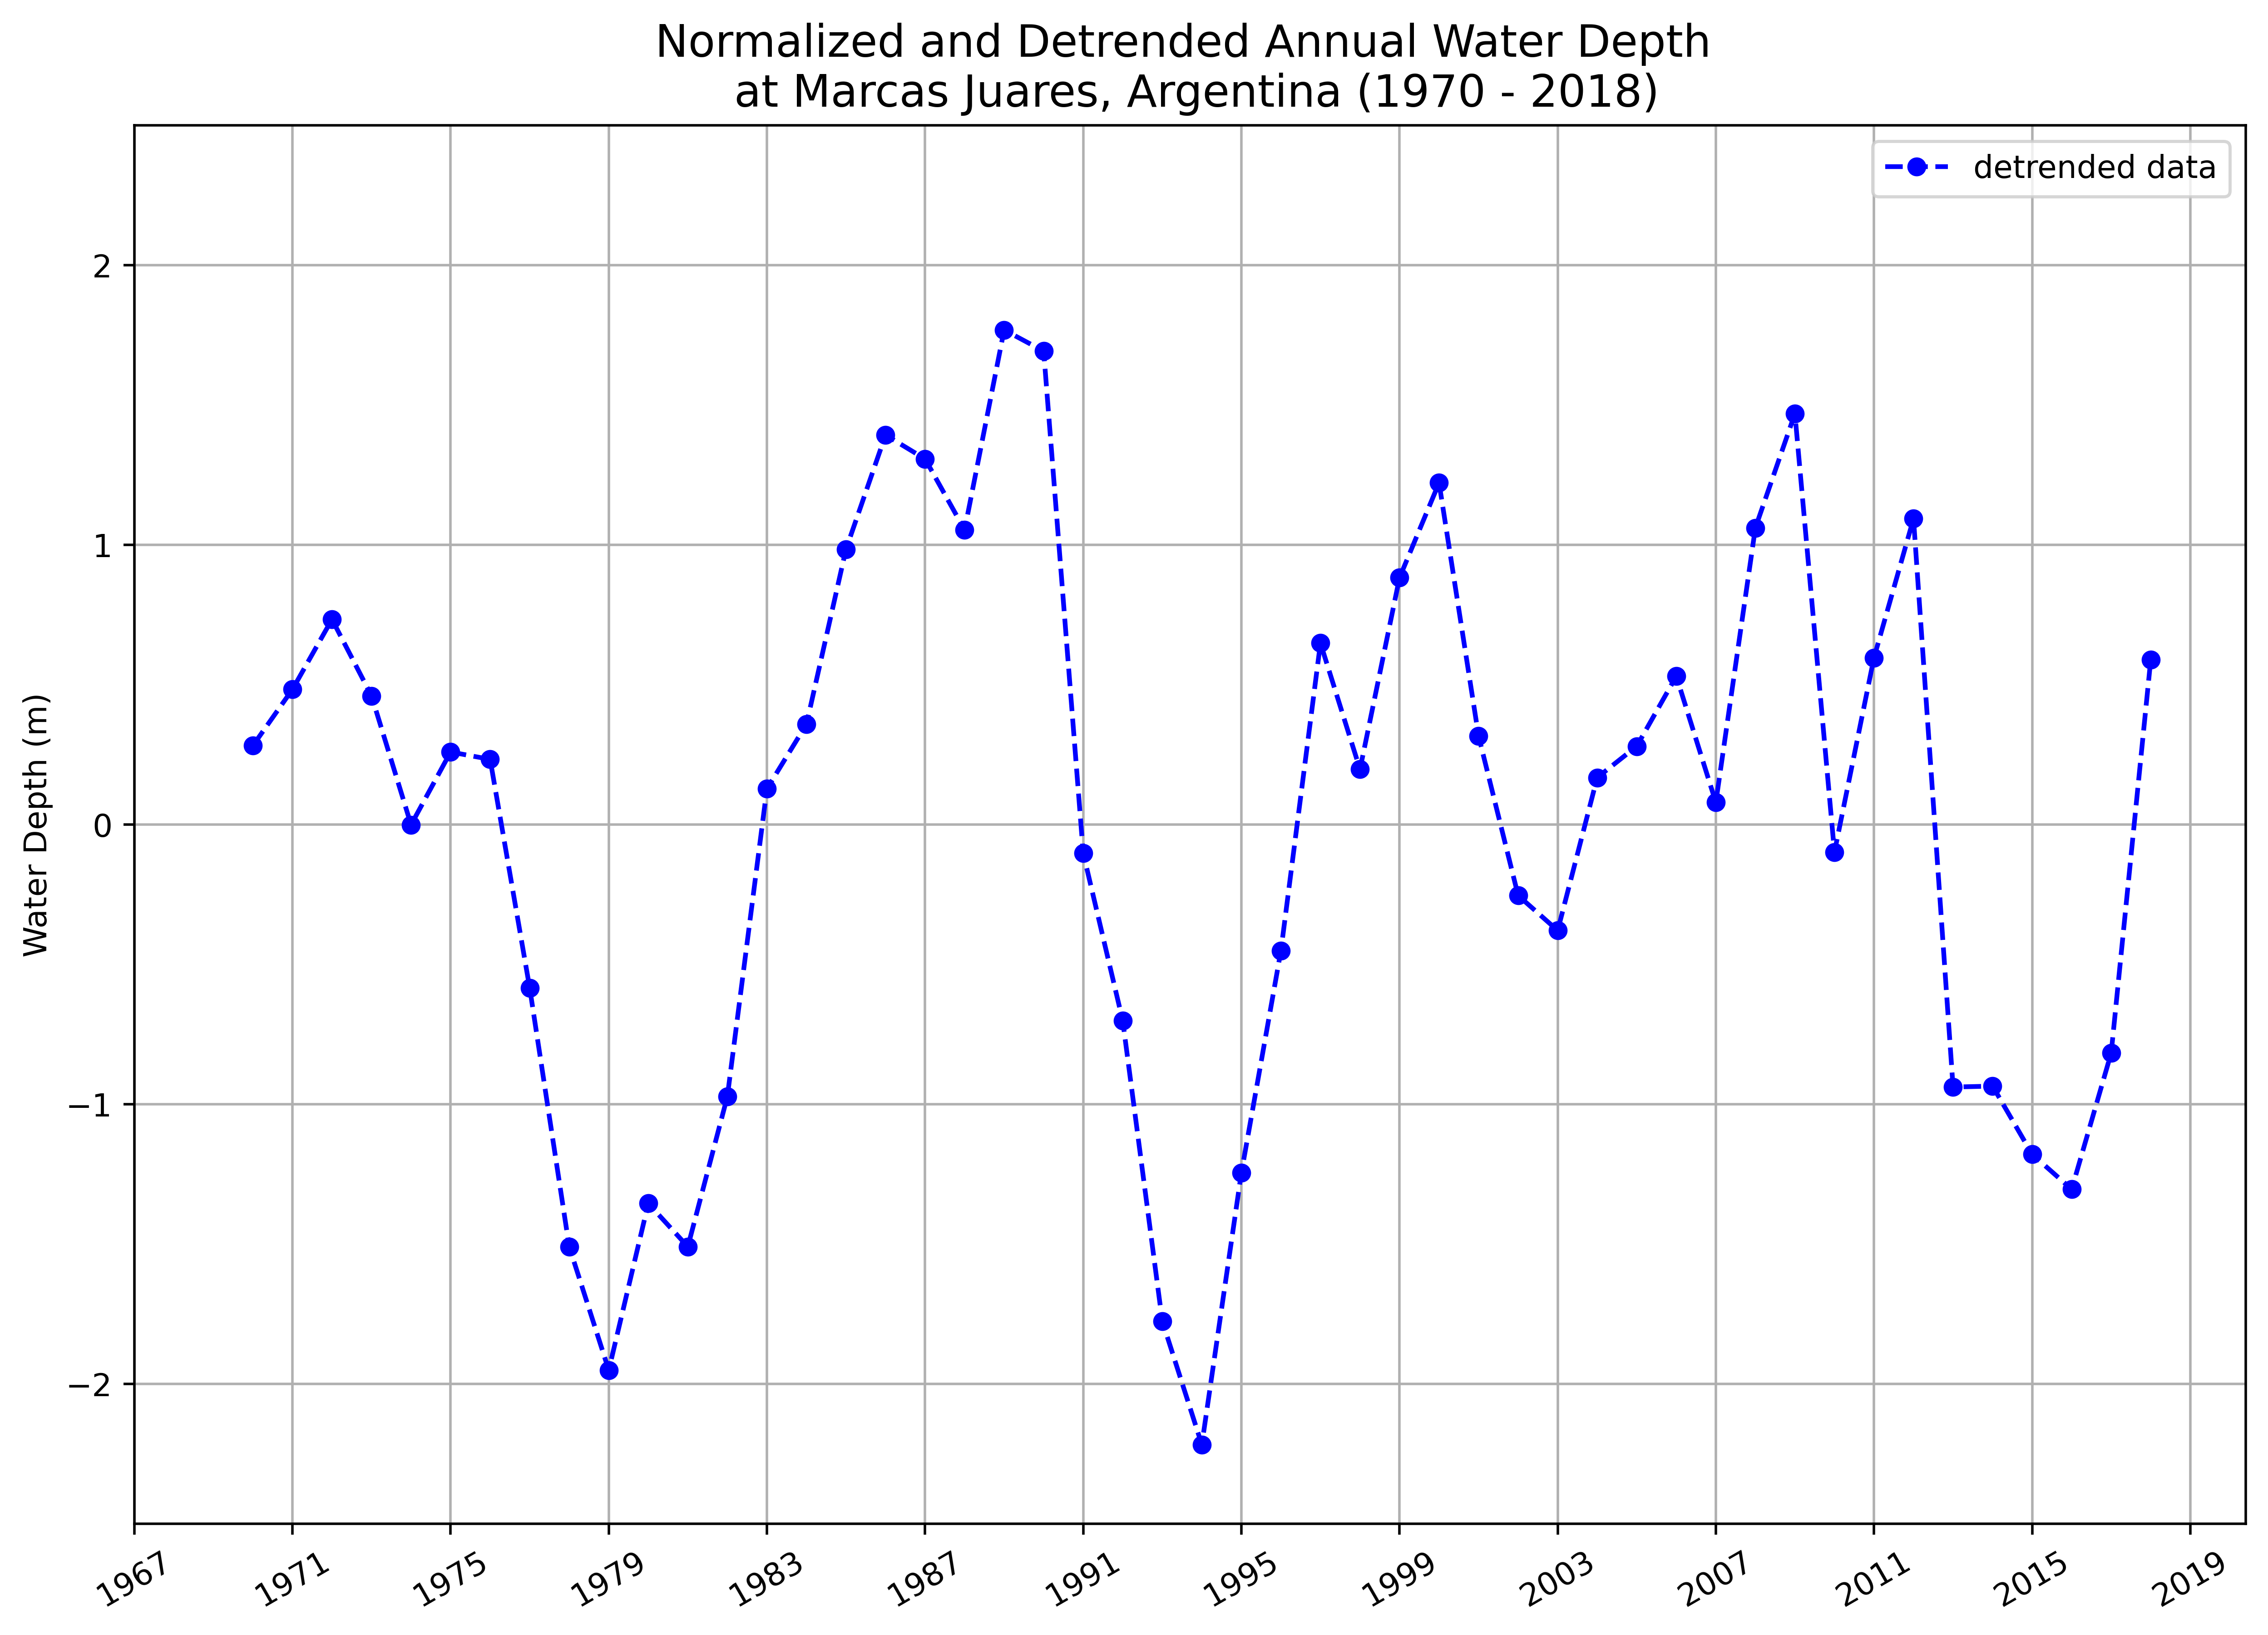

In [8]:
### remove the linear data from the fited linear regression 

# import module for linear regression to ease the computation
from scipy.stats import linregress

# fit a linear regression line
slope, intercept, _, _, _ = linregress(X, Y)
detrended_Y = Y - (slope * X + intercept)

# Compute mean and standard deviation
mean_detrended = np.mean(detrended_Y)
std_detrended = np.std(detrended_Y)

# manually normalize the detrended data to have variance 1
normalized_Y_manual = (detrended_Y - mean_detrended) / std_detrended

### try to plot the original data and detrended data
fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=500)

#ax.plot(X, Y, color='b', marker='o', markersize=5, label='original data')
ax.plot(X, normalized_Y_manual, color='b', linestyle='--', marker='o', markersize=5, label='detrended data')
ax.set_title('Normalized and Detrended Annual Water Depth \n at Marcas Juares, Argentina (1970 - 2018)', fontsize=14)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start-0.6, end-0.4, 4))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
ax.set_ylim(-2.5, 2.5)
plt.xticks(rotation=30)
ax.grid(True)
ax.set_ylabel('Water Depth (m)')
ax.legend()


### 4. Perform Singular Spectrum Analysis (SSA) with `M` = 20, and plot the first four eigenvectors

In [9]:
# define SSA parameters for the detrended data
n = len(normalized_Y_manual)
M = 20

# define new matrix for SSA
numbx = n - M + 1 # number of variables

A = np.zeros((M, numbx))

for i in range(numbx):
    A[:, i] = normalized_Y_manual[i:i + M]

print(A.shape)

# the actual matrix is a numbx by M
A = np.transpose(A)

# mean
mnA = np.mean(A,0,keepdims=True)

# anomalies
Ap = A - mnA

# covariance Matrix
S = (1/(n-1))* np.dot(np.transpose(Ap),Ap)
print('Covariance Matrix Shape',S.shape)
#print('Covariance Matrix')

# print the array with two significant digits per element
np.set_printoptions(precision=2, suppress=True)
#for row in S:
#    print(" ".join(f"{num:.2f}" for num in row))

# calculate eigenvalues and eigenvectors
l, E = np.linalg.eig(S) # l is eigenvalues and E is eigenvectors

print('Eigenvectors',E.shape)
print('Eigenvalues',l.shape)


(20, 30)
Covariance Matrix Shape (20, 20)
Eigenvectors (20, 20)
Eigenvalues (20,)


Text(0.5, 0, 'Eigenvalue order')

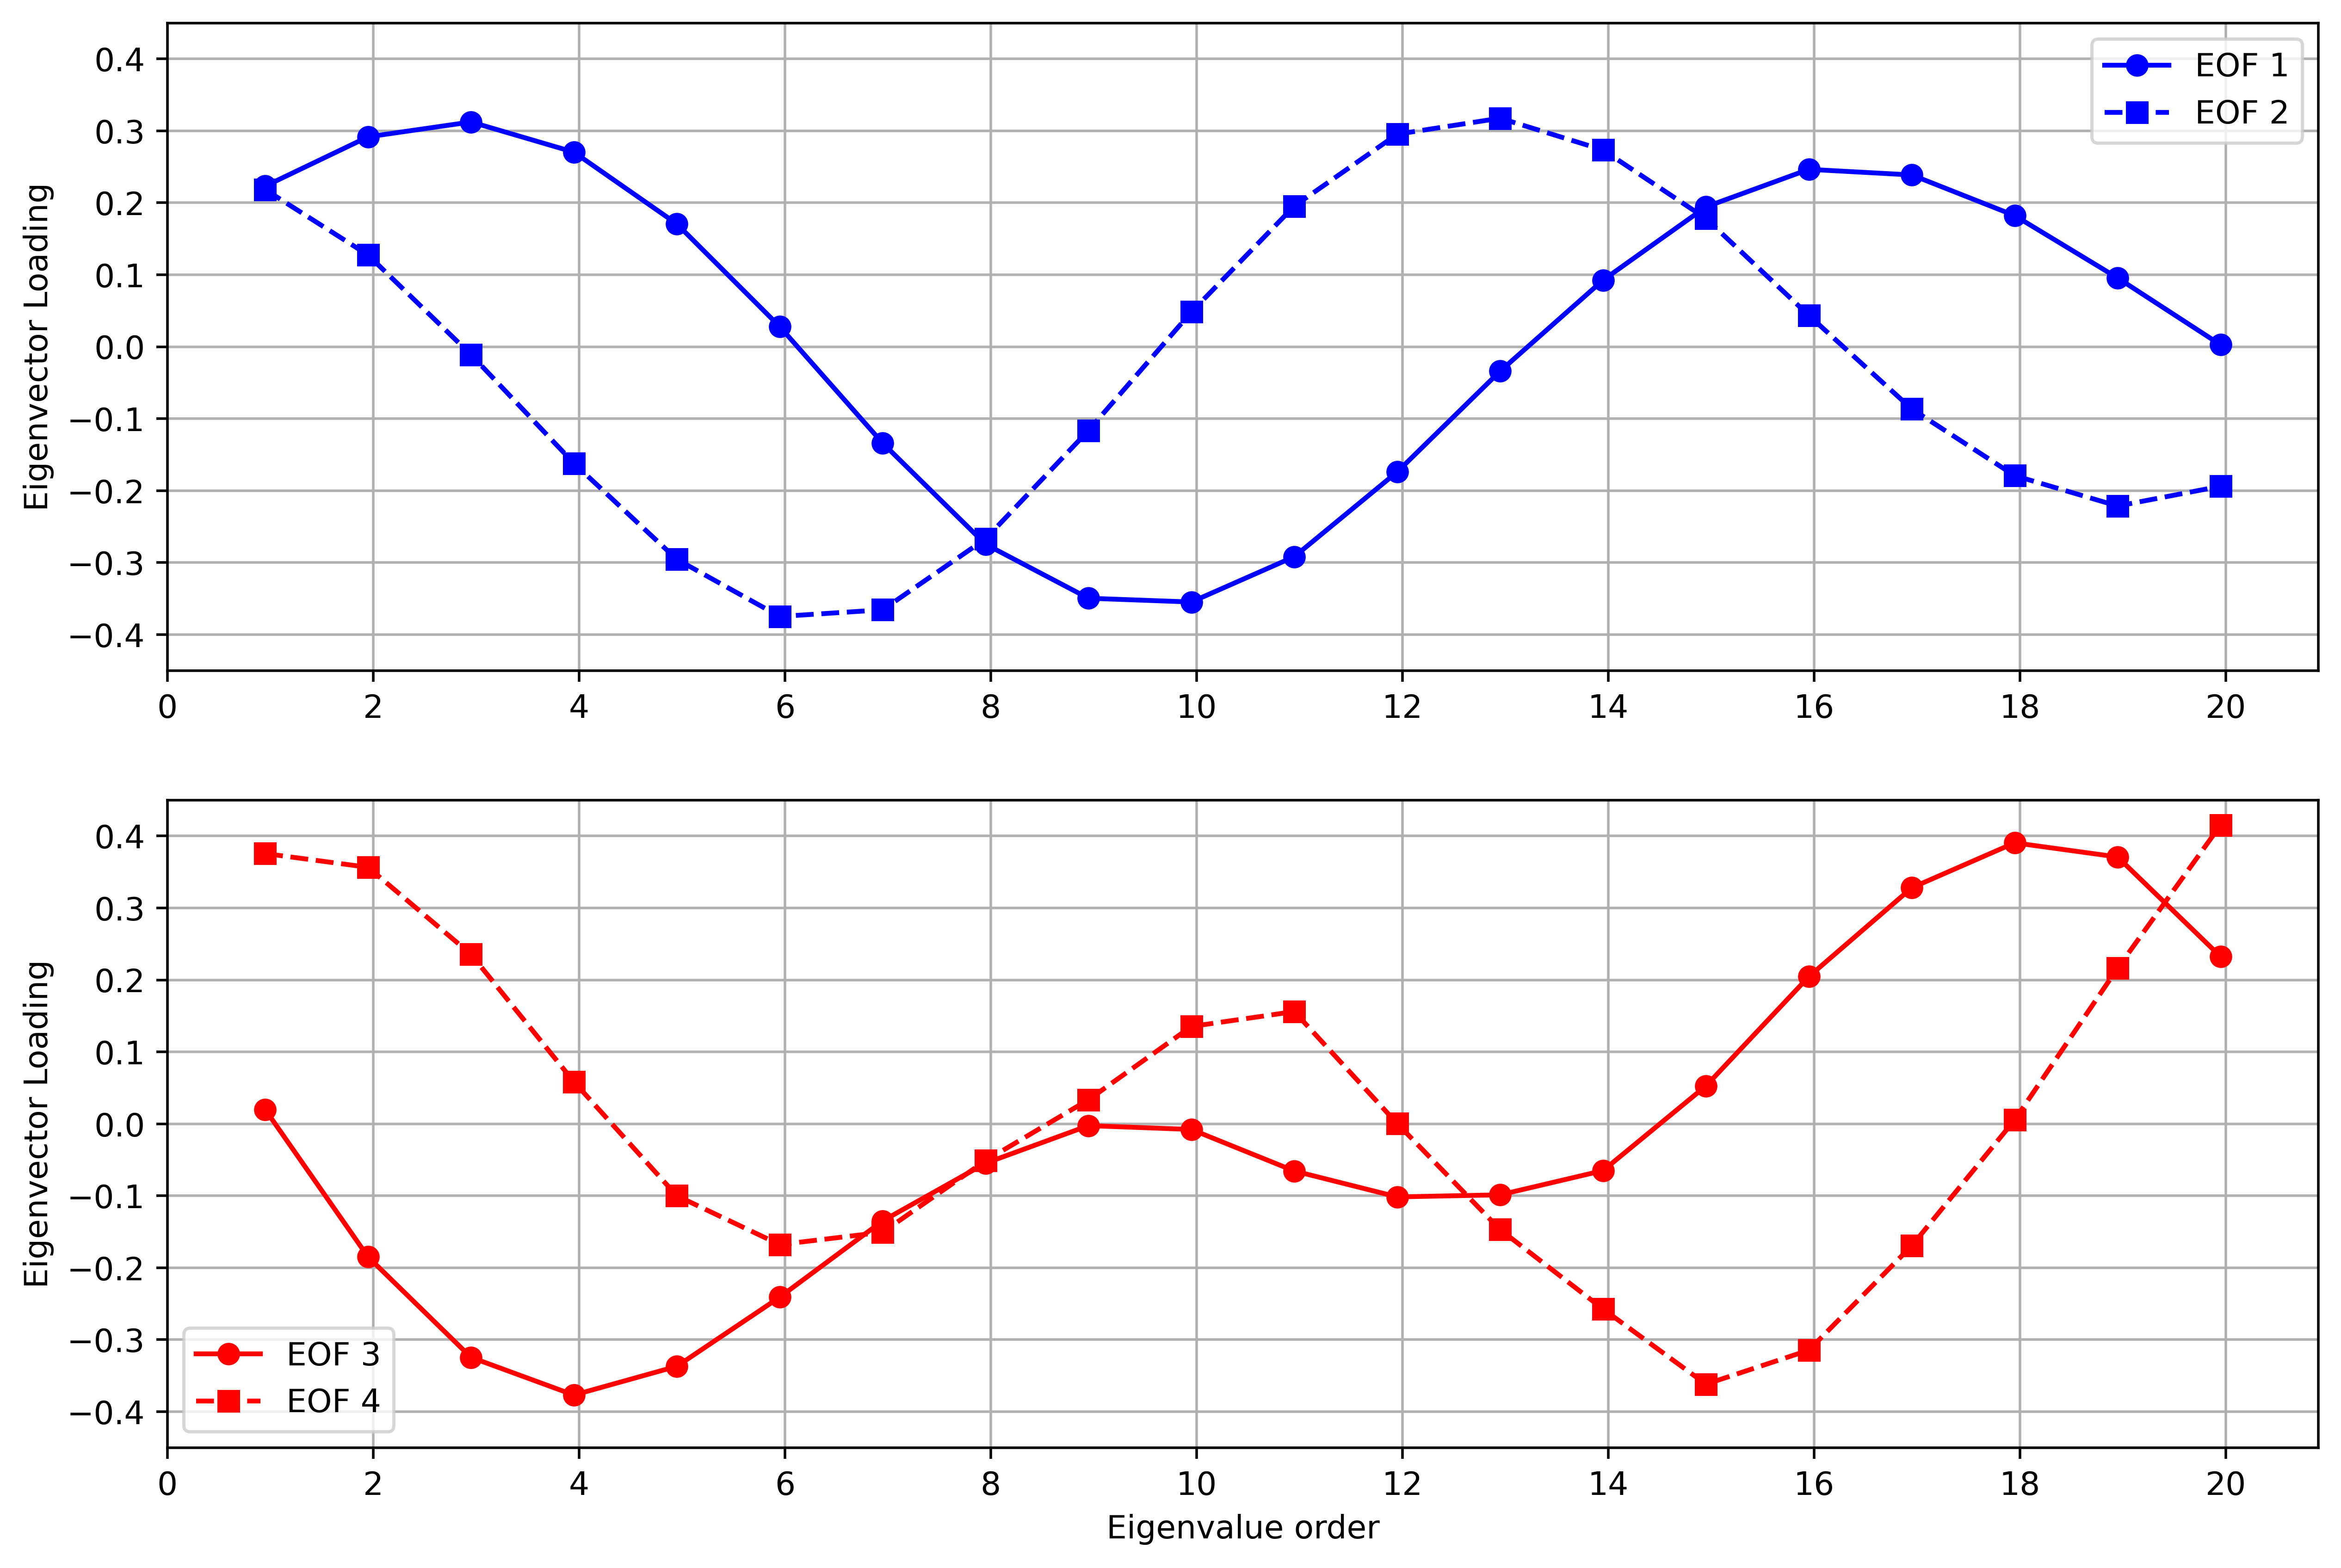

In [42]:
### plot the first four eigenvectors in pairs

# create an array of x-values
x = range(1, len(l)+1)
#x = range(1, 21)

# create a plot
fig, axs = plt.subplots(2, 1, figsize=(12, 8), dpi=500)
(ax1, ax2) = axs

# create the line plot for the first pair Two EOFs
#ax1.plot(X, normalized_Y_manual, color='k', linestyle='-', marker='o', markersize=5, label='ori detrended data')
ax1.plot(x, E[:,0], label='EOF 1', marker='o', linestyle='-', color='b')
ax1.plot(x, E[:,1], label='EOF 2', marker='s', linestyle='--', color='b')
ax1.set_ylabel('Eigenvector Loading')
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end, 2))
ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
ax1.set_ylim(-0.45, 0.45)
ax1.grid()
ax1.legend()

# create the line plot for the second pairs Two EOFs
ax2.plot(x, E[:,2], label='EOF 3', marker='o', linestyle='-', color='r')
ax2.plot(x, E[:,3], label='EOF 4', marker='s', linestyle='--', color='r')
ax2.set_ylabel('Eigenvector Loading')
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start, end, 2))
ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
ax2.set_ylim(-0.45, 0.45)
ax2.grid()
ax2.legend()
ax2.set_xlabel('Eigenvalue order')

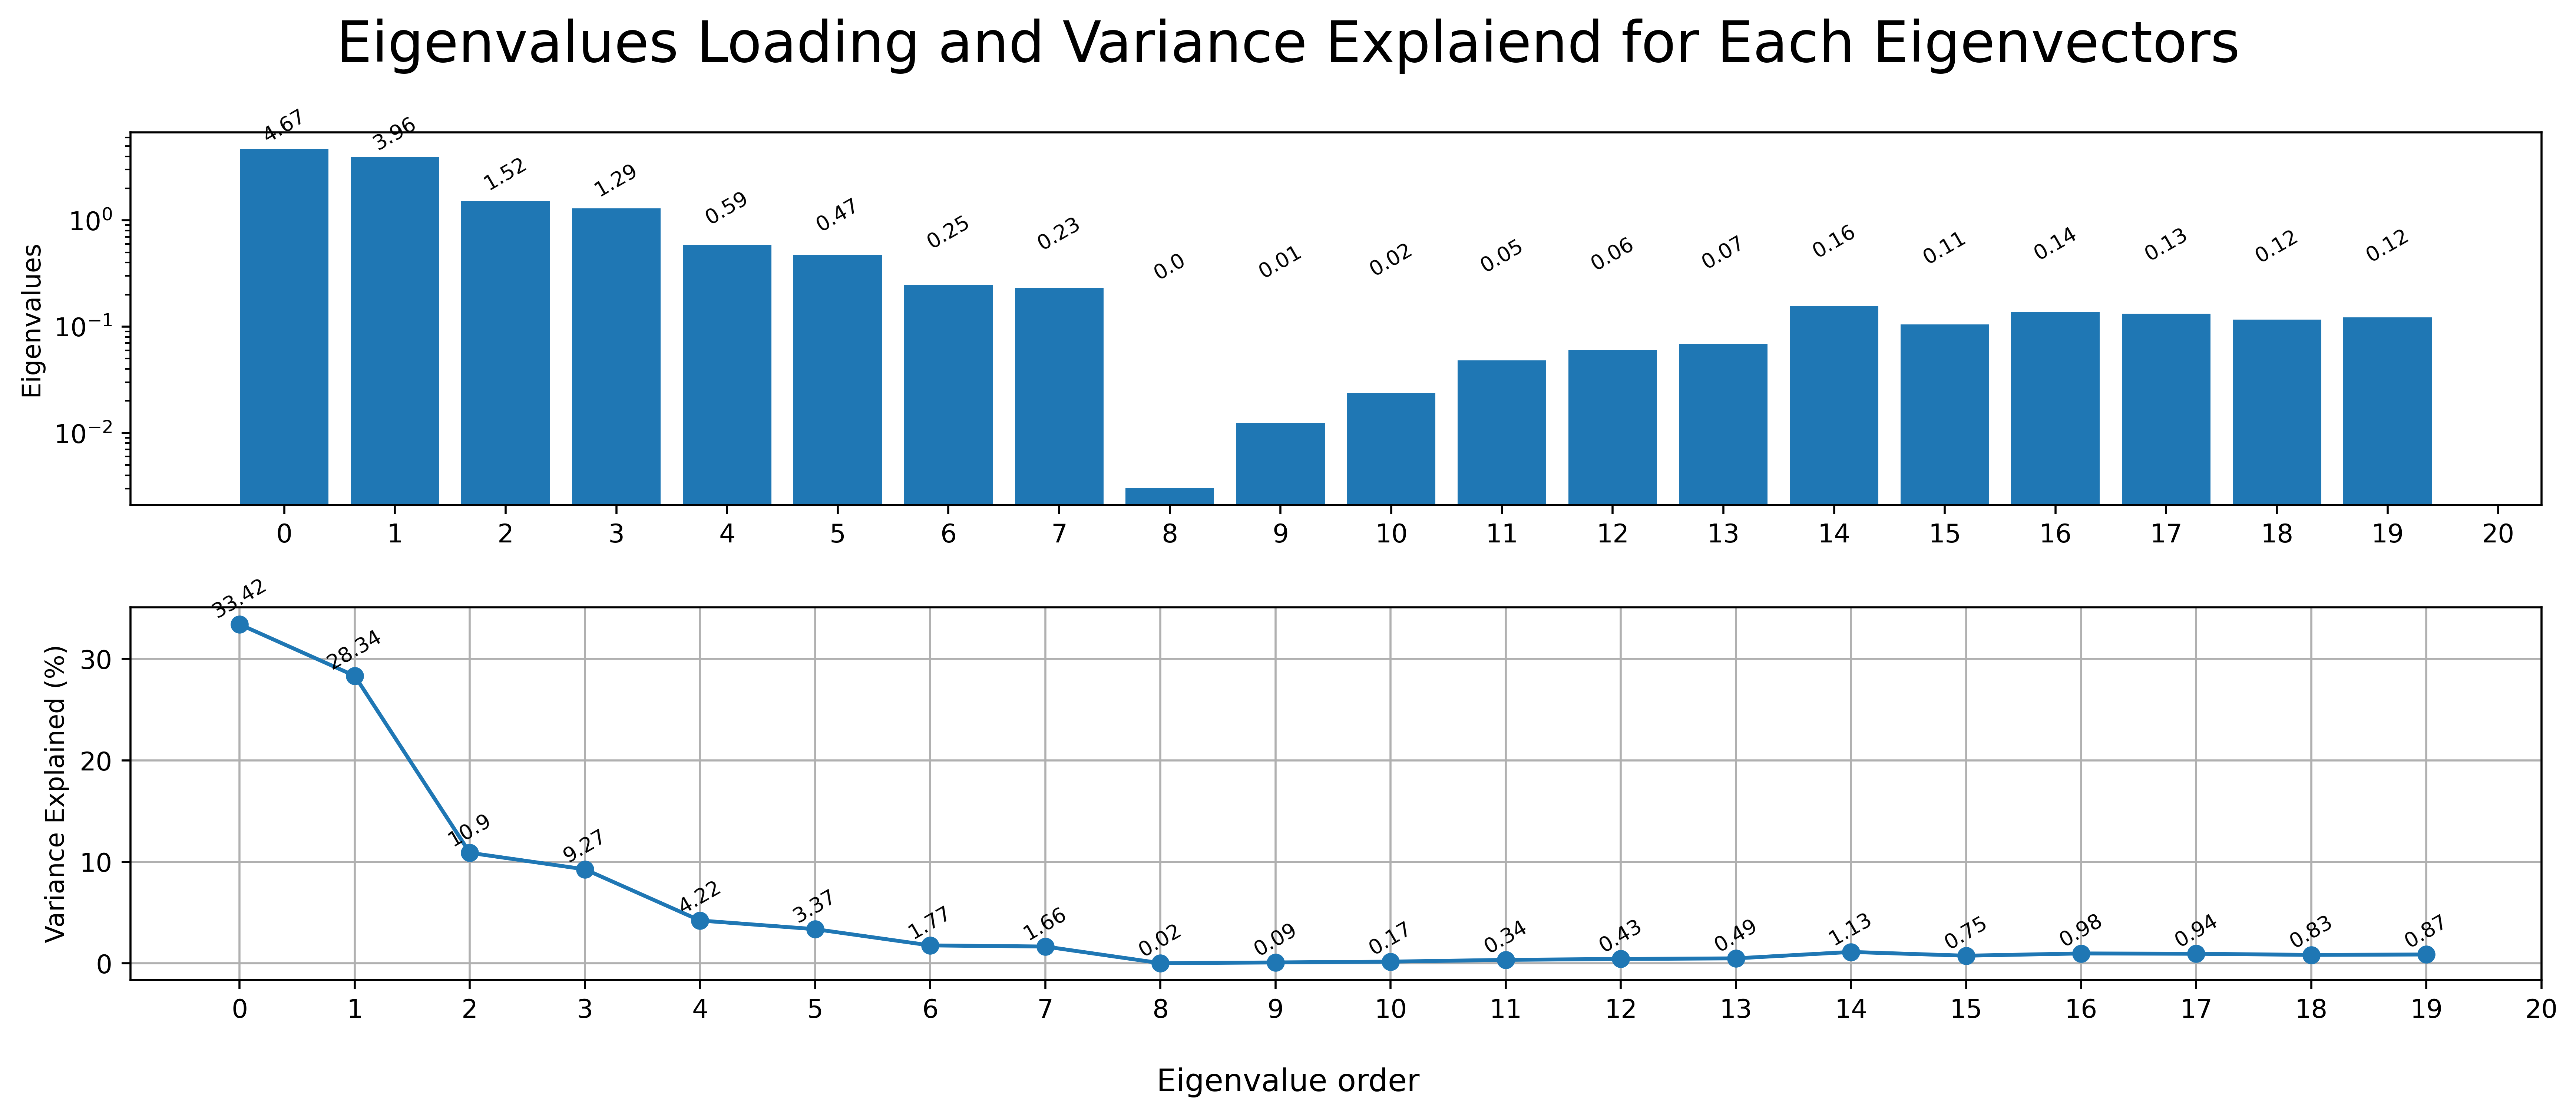

In [41]:
### plot eigen values and variamce explained
fig, axs = plt.subplots(2, 1, figsize=(14, 6), dpi=500)
(ax1, ax2) = axs

### plot eigenvalues for first 10 EOFS for manual
ax1.bar(range(len(l)), l)
for i, value in enumerate(l):
    ax1.text(i, value +0.25, str(round(value,2)), ha='center', va='bottom', rotation=30, fontsize=8)
ax1.set_xticks(range(0, len(l)+1));
ax1.set_yscale('log')
fig.suptitle('Eigenvalues Loading and Variance Explaiend for Each Eigenvectors', fontsize=22)
fig.supxlabel('Eigenvalue order')
ax1.set_ylabel('Eigenvalues')

### calculate variance explained
var_exp = l/(np.sum(l))*100
ax2.plot(range(len(var_exp)), var_exp, marker='o', label = 'manual')
ax2.set_xticks(range(0, len(var_exp)+1));
for i, value in enumerate(var_exp):
    ax2.text(i, value +0.25, str(round(value,2)), ha='center', va='bottom', rotation=30, fontsize=8)
ax2.set_ylabel('Variance Explained (%)')
ax2.grid(True)
fig.set_tight_layout(True)

### 5. Plot the PCs for each eigenvectors

Manual PC
(20, 30)


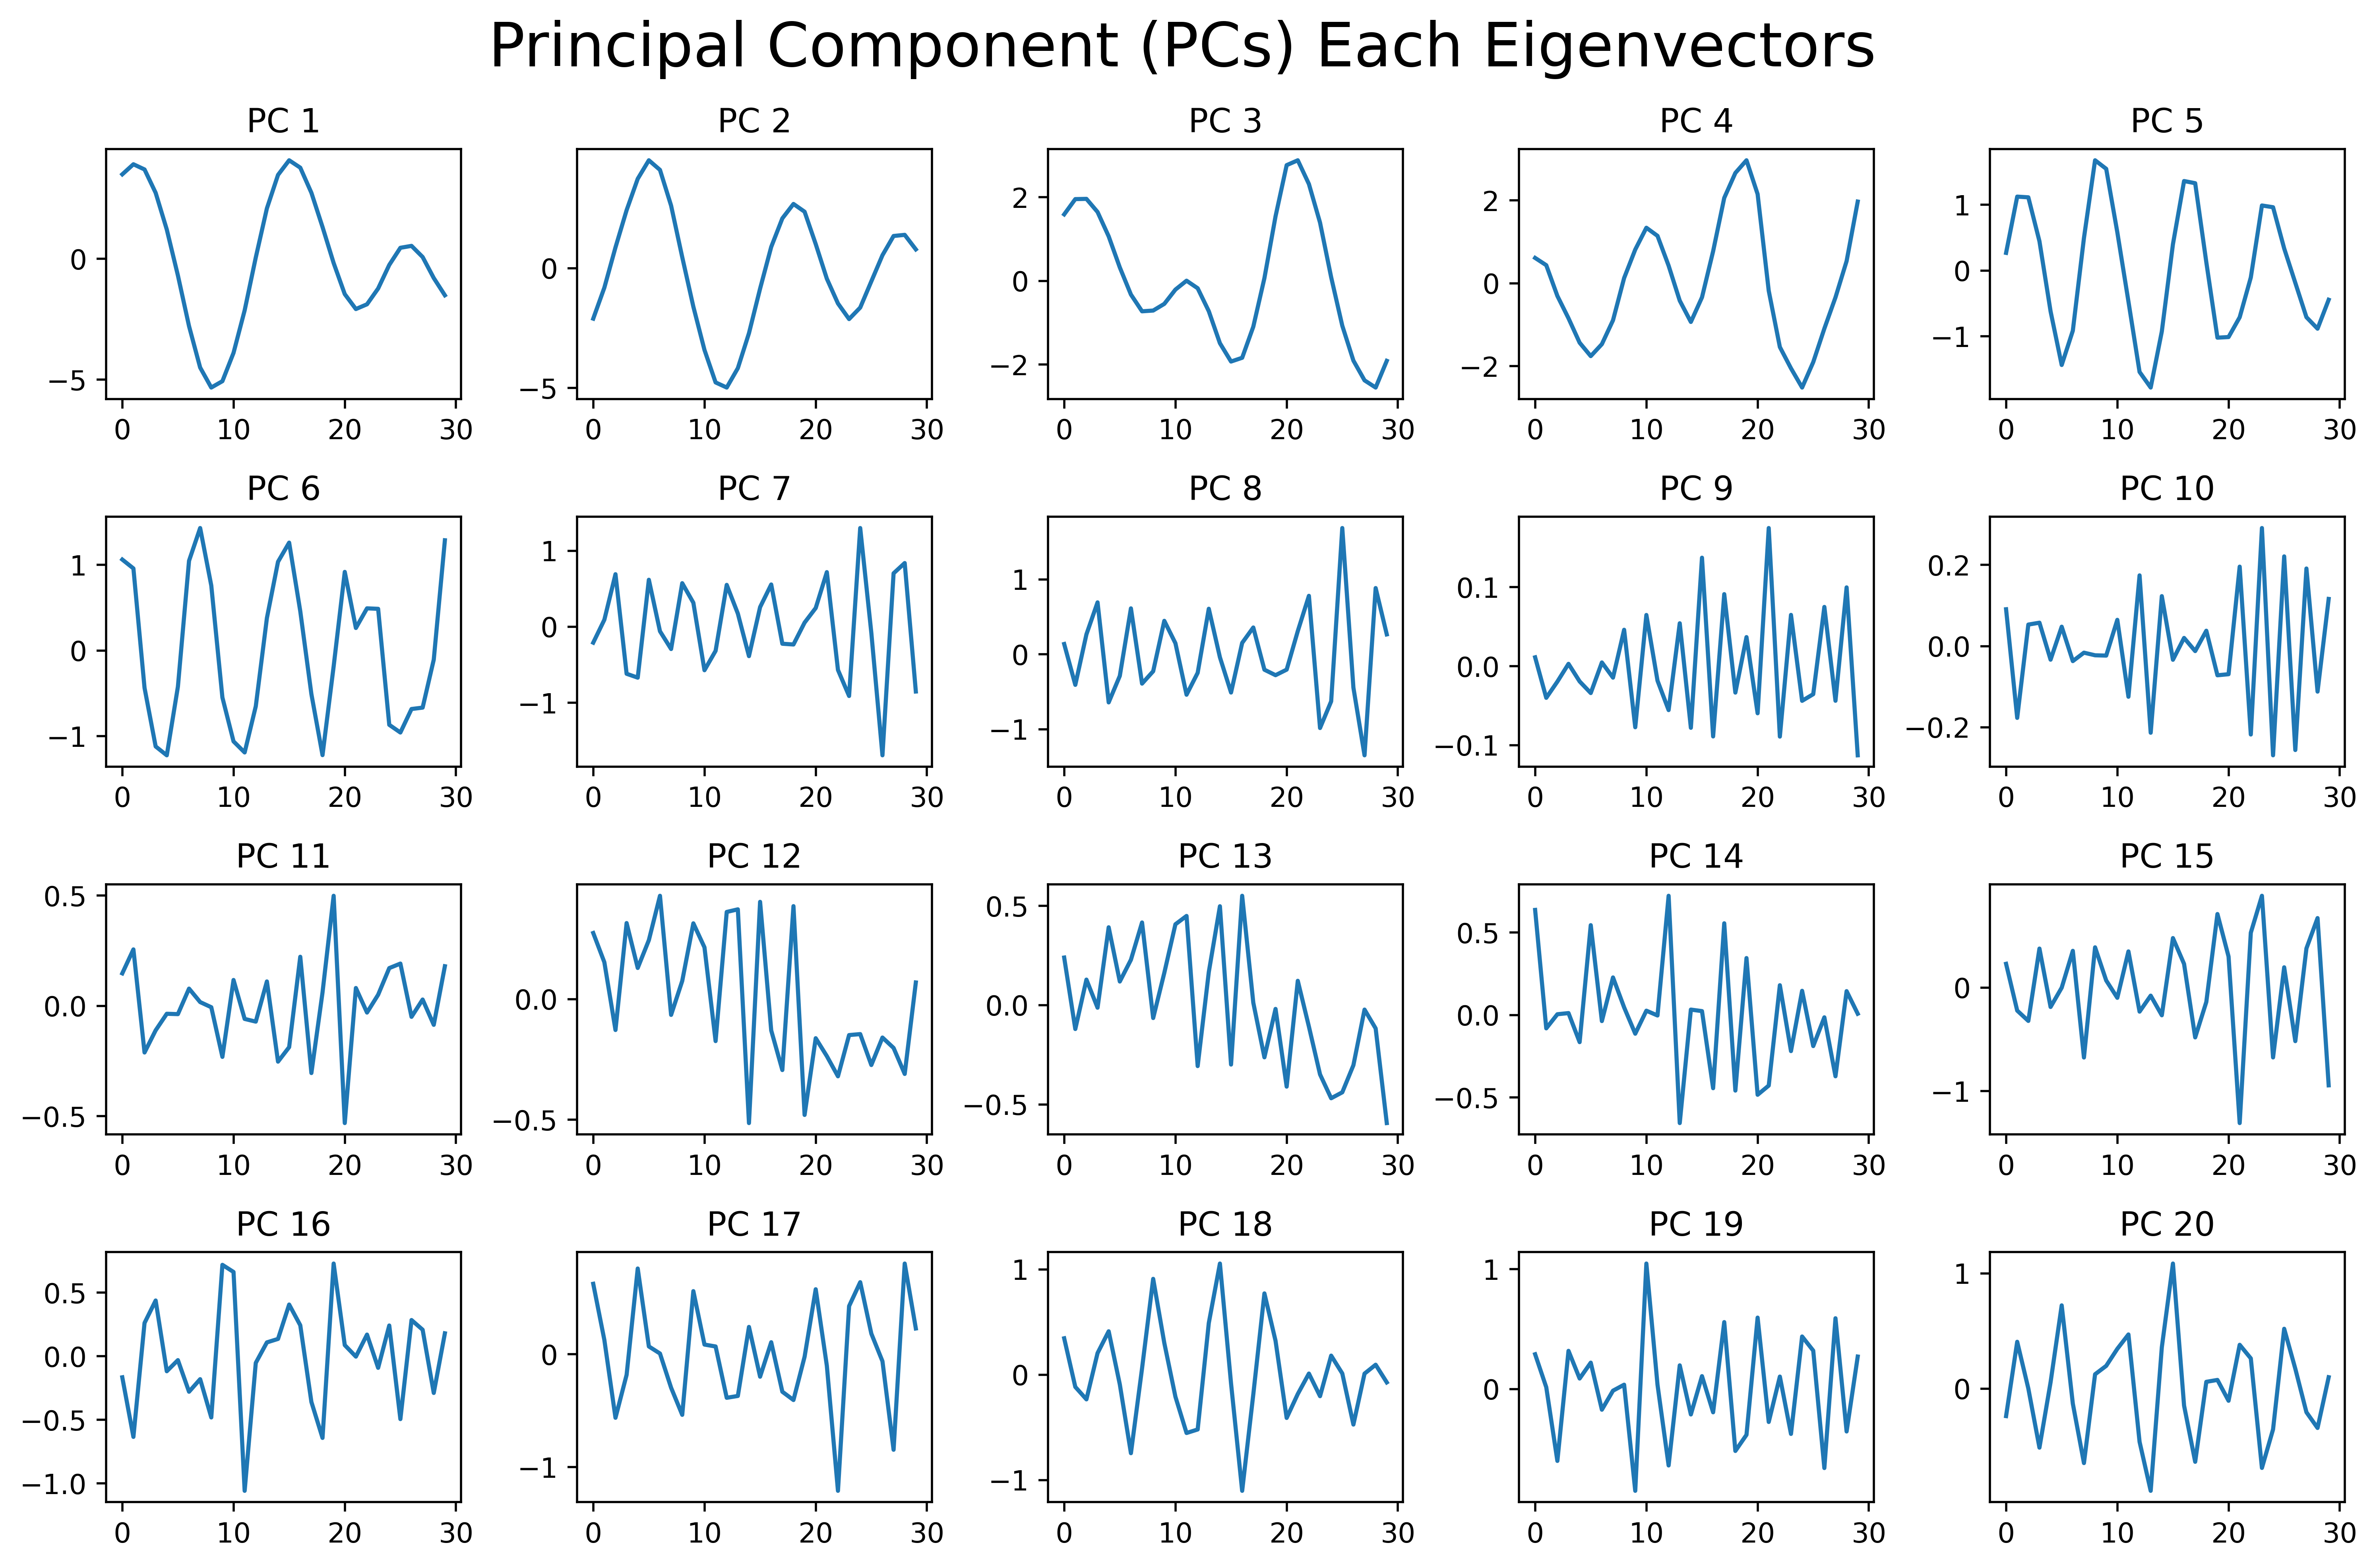

In [12]:
### perform Manual PCs calculation 
# manual PC calculation
u = np.dot(np.transpose(E),np.transpose(Ap))
print('Manual PC')
print(u.shape)

# plot the PCs
# create the line plot for the first Two EOFs
fig, axs = plt.subplots(4, 5, figsize=(12, 8), dpi=500)

for i, ax in enumerate(axs.flat):
    PC = u[i,:]
    ax.plot(range(len(PC)), PC)
    ax.set_title(f'PC {i + 1}')

# adjust layout and show the plots
fig.suptitle('Principal Component (PCs) Each Eigenvectors', fontsize=22)
plt.tight_layout()
plt.show()

### 6. Perform Fourier Analysis

In [13]:
### perform manual Fourier Analysis
# import module
import math

# calculate Fourier
n = len(normalized_Y_manual)
def create_cosine_array(n,k):
    t = np.arange(1, n + 1)  # Array of consecutive numbers from 1 through n
    return np.cos(2 * np.pi * k * t / n)

def create_sine_array(n,k):
    t = np.arange(1, n + 1)  # Array of consecutive numbers from 1 through n
    return np.sin(2 * np.pi* k * t / n)

def calcphi(Ai,Bi):
    if Ai < 0:
      phiarr = math.atan(Bi/Ai)+np.pi
    elif Ai > 0:
      phiarr = math.atan(Bi/Ai)
    elif Ai==0:
      phiarr = np.pi/2

    return phiarr

A, B, C, phi, maxk = [], [], [], [], []
maxk = int((n-1)/2) # odd

# loop from 1 to n (inclusive)
for i in range(1, maxk+1):

    Aele = (2/n) * np.sum(Y * create_cosine_array(n,i))
    Bele = (2/n) * np.sum(Y * create_sine_array(n,i))
    Cele = (Aele**2 + Bele**2)**0.5
    phiele = calcphi(Aele, Bele)
    A.append(Aele)
    B.append(Bele)
    C.append(Cele)
    phi.append(phiele)

# print the result array
A = np.array(A)
B = np.array(B)
C = np.array(C)
phi = np.array(phi)

# creating a Pandas DataFrame
dff = pd.DataFrame({
    'A': A,
    'B': B,
    'C': C,
    'phi': phi
})

# displaying the DataFrame
pd.set_option('display.float_format', lambda x: f'{x:.2f}')
print(dff)


       A     B    C  phi
0  -0.33  2.66 2.68 1.69
1  -0.30  1.15 1.18 1.83
2   0.27  1.58 1.60 1.40
3  -0.88  1.20 1.49 2.21
4   0.18  0.68 0.70 1.32
5  -0.30  0.37 0.47 2.26
6   0.13  0.52 0.54 1.33
7  -0.18  0.41 0.45 1.98
8  -0.08  0.25 0.26 1.87
9  -0.24  0.34 0.42 2.19
10 -0.13  0.10 0.17 2.48
11 -0.24  0.04 0.24 2.96
12 -0.25  0.25 0.35 2.34
13 -0.02  0.20 0.20 1.67
14 -0.08  0.32 0.33 1.81
15 -0.05  0.03 0.06 2.56
16 -0.06 -0.04 0.07 3.68
17 -0.25  0.04 0.25 2.97
18 -0.19  0.08 0.21 2.75
19 -0.29  0.11 0.31 2.78
20 -0.07  0.05 0.09 2.57
21 -0.17  0.04 0.18 2.93
22 -0.14  0.06 0.15 2.73
23 -0.13  0.01 0.13 3.04


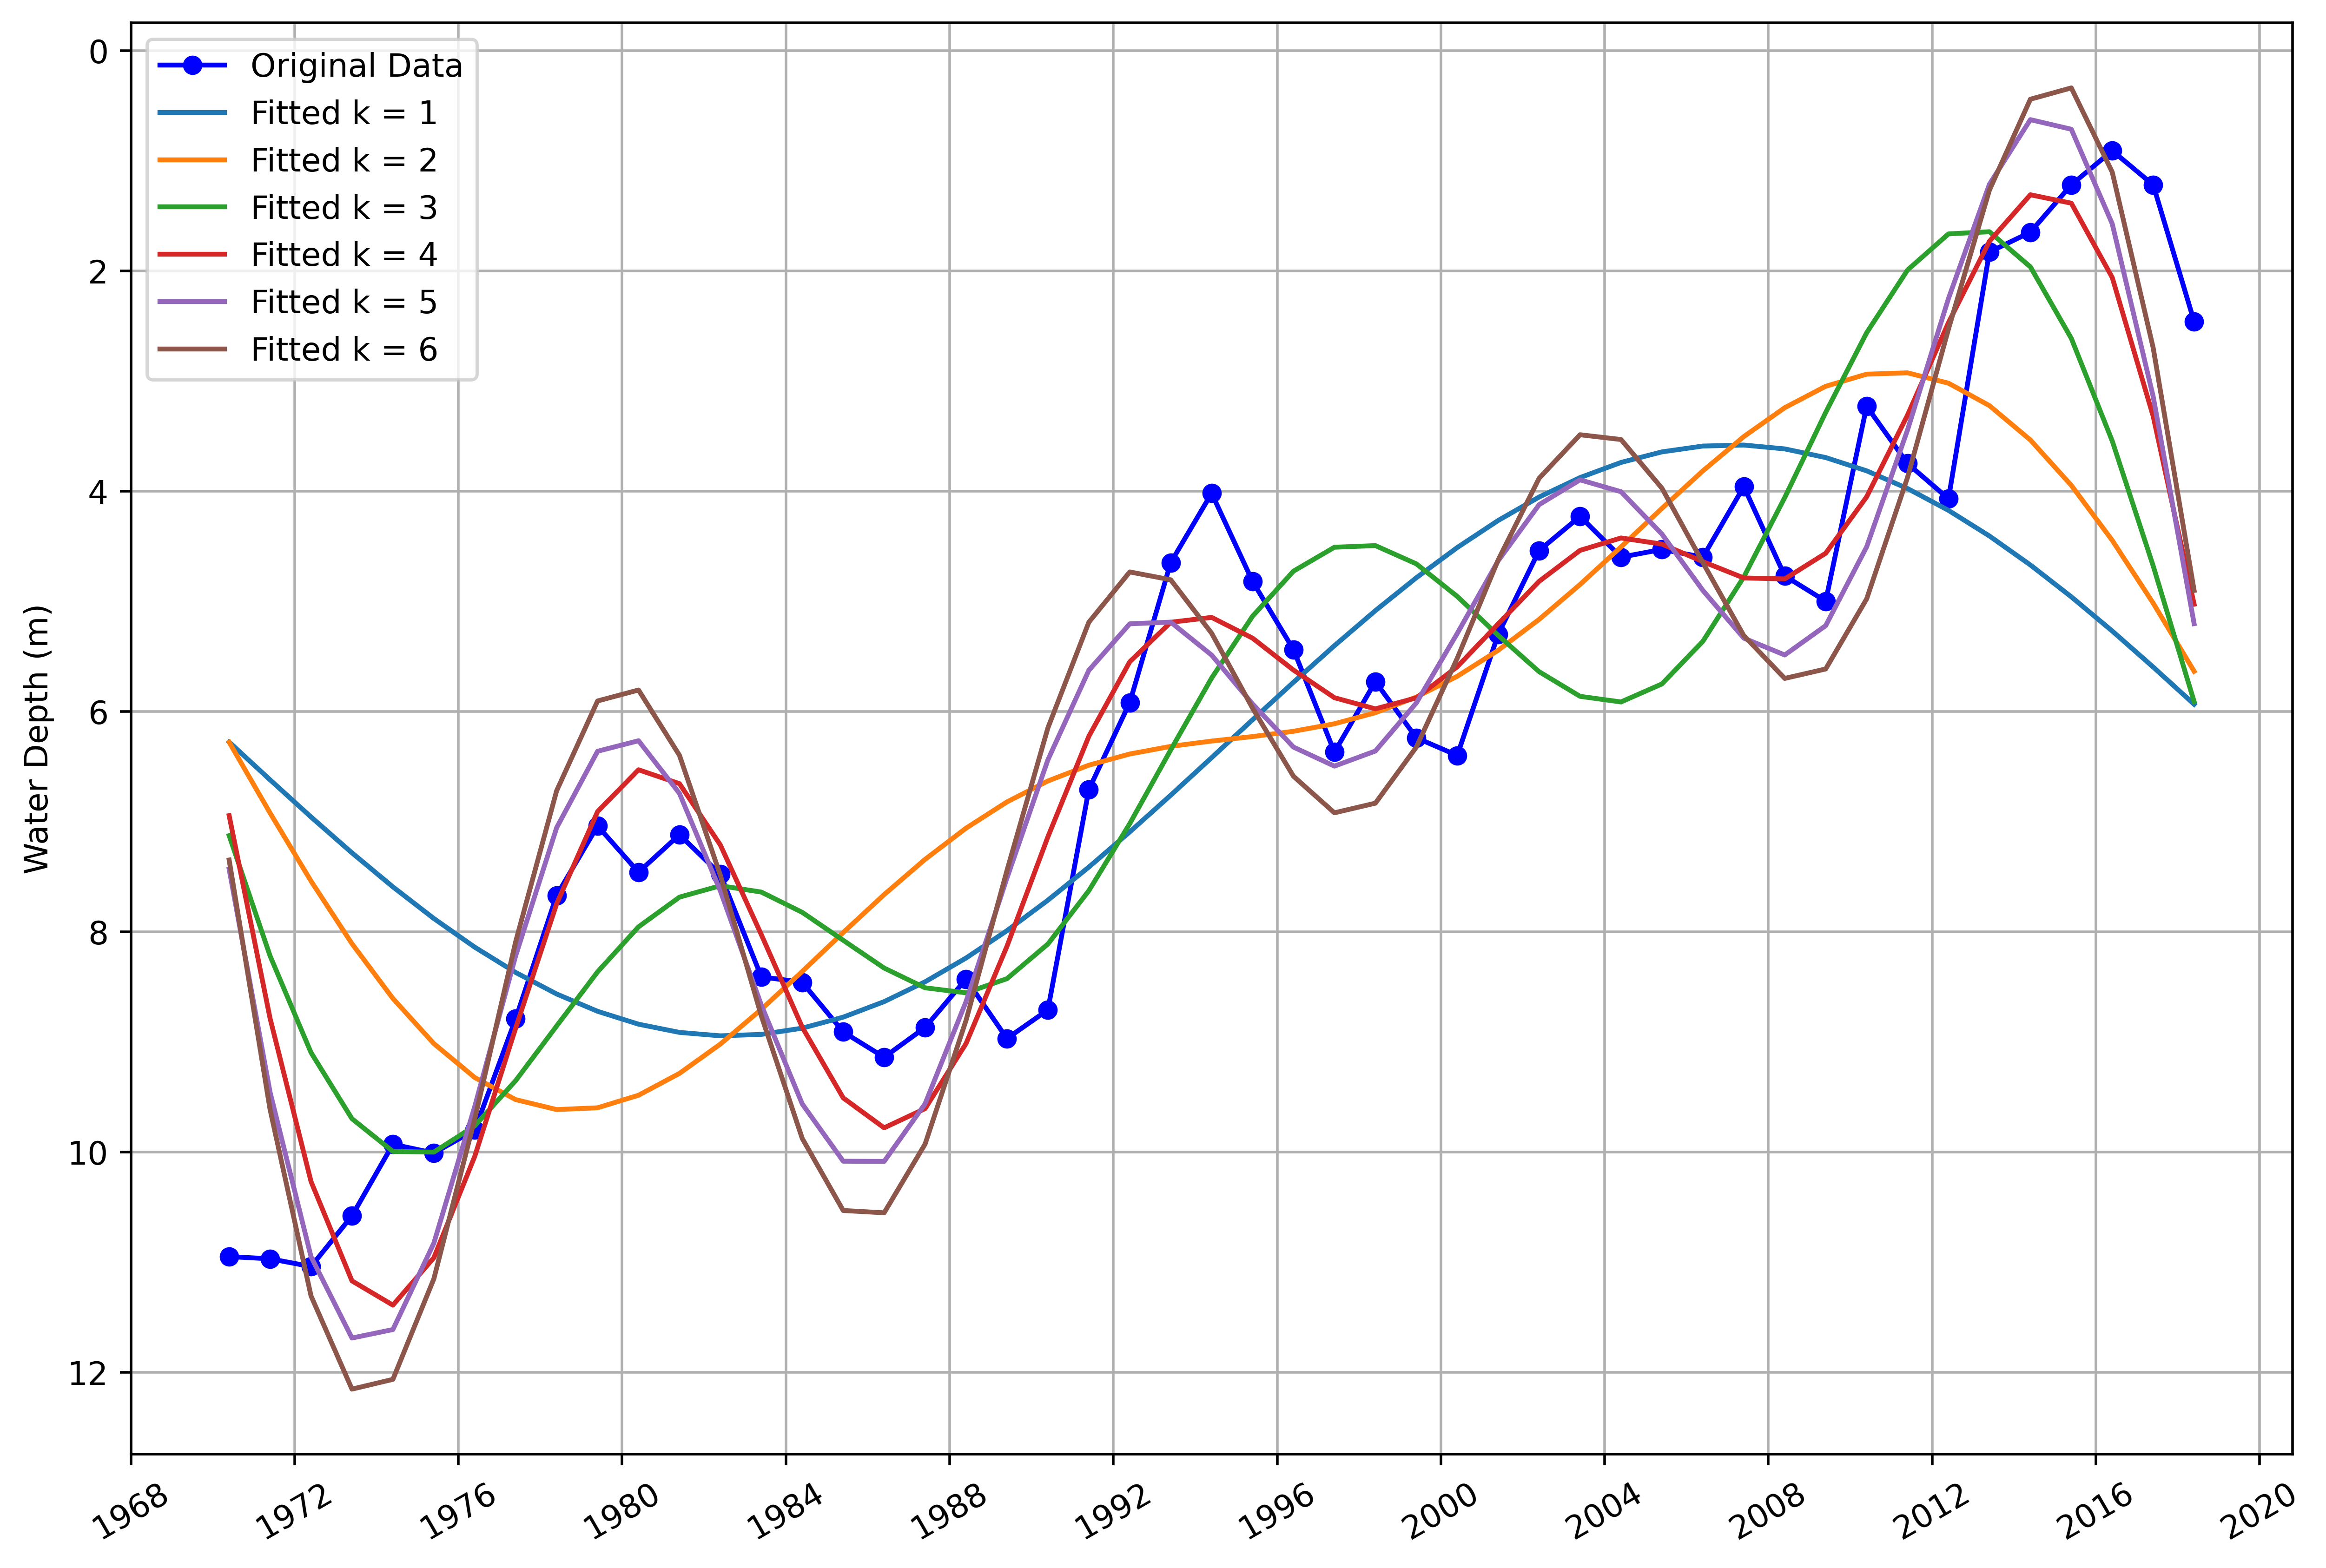

In [14]:
### plot to see the time series and the fitted data
ybar = np.mean(Y)
ystd = np.std(Y)

fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=500)
t = np.arange(1, n + 1)
har1 = ybar + C[0]*np.cos(2*np.pi*t/n - phi[0])
har2 = har1 + C[1]*np.cos(2*np.pi*2*t/n - phi[1])
har3 = har2 + C[2]*np.cos(2*np.pi*3*t/n - phi[2])
har4 = har3 + C[3]*np.cos(2*np.pi*4*t/n - phi[3])
har5 = har4 + C[4]*np.cos(2*np.pi*4*t/n - phi[4])
har6 = har5 + C[5]*np.cos(2*np.pi*4*t/n - phi[5])

fitted = [har1, har2, har3, har4, har5, har6]
labels = ['Fitted k = 1', 'Fitted k = 2', 'Fitted k = 3', 'Fitted k = 4', 'Fitted k = 5', 'Fitted k = 6']

ax.plot(X, Y, color='b', marker='o', markersize=5, label='Original Data')
for i, (y, label) in enumerate(zip(fitted, labels)):
    ax.plot(X, y, label=label)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 4))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
plt.xticks(rotation=30)
ax.invert_yaxis()
ax.grid(True)
ax.set_ylabel('Water Depth (m)')
ax.legend()


In [15]:
### calculate Ck and Rk
# put new column for storing Ck and Rk
dff['C2'] = (dff['C'])**2
dff['R2'] = (n/2)*dff['C2']/((n-1)*ystd**2)

# displaying the DataFrame
pd.set_option('display.float_format', lambda x: f'{x:.2f}')
print(dff)

       A     B    C  phi   C2   R2
0  -0.33  2.66 2.68 1.69 7.20 0.47
1  -0.30  1.15 1.18 1.83 1.40 0.09
2   0.27  1.58 1.60 1.40 2.58 0.17
3  -0.88  1.20 1.49 2.21 2.22 0.15
4   0.18  0.68 0.70 1.32 0.49 0.03
5  -0.30  0.37 0.47 2.26 0.22 0.01
6   0.13  0.52 0.54 1.33 0.29 0.02
7  -0.18  0.41 0.45 1.98 0.20 0.01
8  -0.08  0.25 0.26 1.87 0.07 0.00
9  -0.24  0.34 0.42 2.19 0.18 0.01
10 -0.13  0.10 0.17 2.48 0.03 0.00
11 -0.24  0.04 0.24 2.96 0.06 0.00
12 -0.25  0.25 0.35 2.34 0.13 0.01
13 -0.02  0.20 0.20 1.67 0.04 0.00
14 -0.08  0.32 0.33 1.81 0.11 0.01
15 -0.05  0.03 0.06 2.56 0.00 0.00
16 -0.06 -0.04 0.07 3.68 0.01 0.00
17 -0.25  0.04 0.25 2.97 0.06 0.00
18 -0.19  0.08 0.21 2.75 0.04 0.00
19 -0.29  0.11 0.31 2.78 0.10 0.01
20 -0.07  0.05 0.09 2.57 0.01 0.00
21 -0.17  0.04 0.18 2.93 0.03 0.00
22 -0.14  0.06 0.15 2.73 0.02 0.00
23 -0.13  0.01 0.13 3.04 0.02 0.00


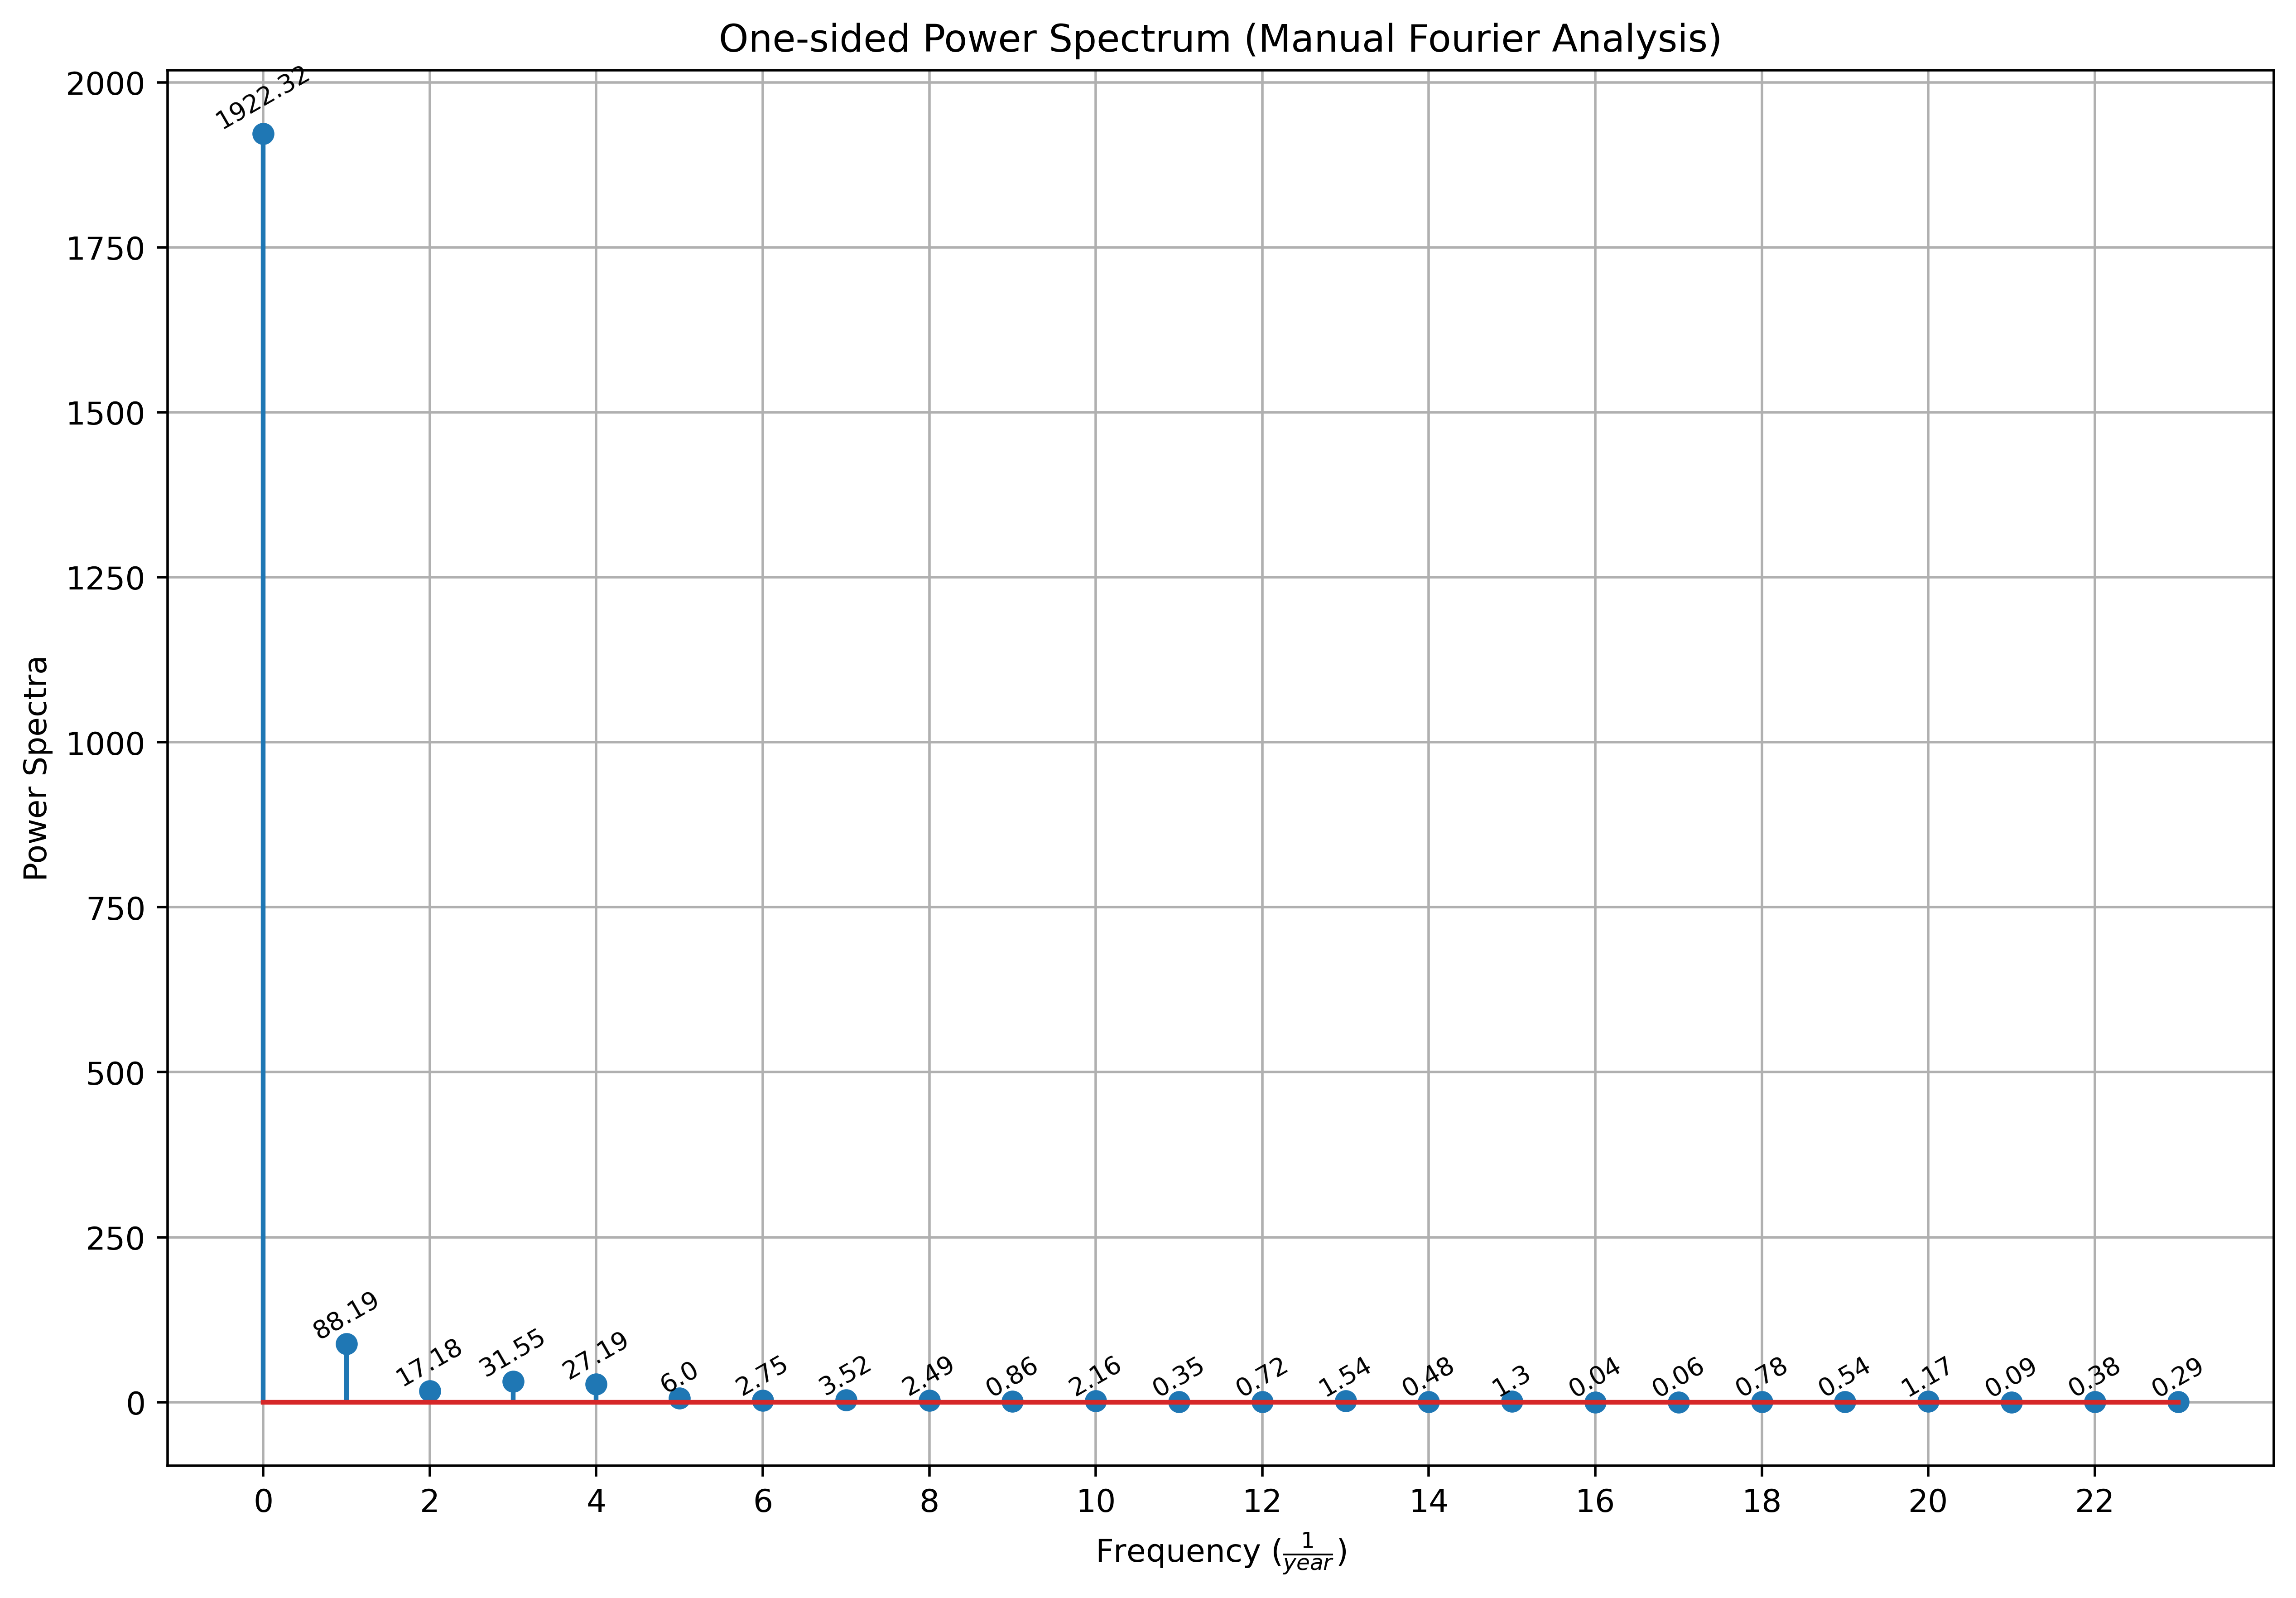

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Your data array
data_array = df.values

# Extract the signal values from the second column
signal_values = data_array[:, 1]

# Perform manual Fourier analysis
N = len(signal_values)
frequencies = np.arange(N) / (data_array[1, 0] - data_array[0, 0])

fourier_result = []

for k in range(N):
    X_k = np.sum(signal_values * np.exp(-1j * 2 * np.pi * k * np.arange(N) / N))
    fourier_result.append(X_k)

# Compute the one-sided power spectrum
power_spectrum = np.abs(fourier_result[:N//2])**2 / N

# Plot the one-sided power spectrum
fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=500)
ax.stem(frequencies[:len(frequencies)//2], power_spectrum)
for i, value in enumerate(power_spectrum):
    ax.text(i, value +0.25, str(round(value,2)), ha='center', va='bottom', rotation=30, fontsize=8)
ax.set_xlabel(r'Frequency ($\frac{1}{year}$)')
#ax.set_yscale('log')
num_ticks = 20 
step_size = len(frequencies) // num_ticks
ax.set_xticks(frequencies[:len(frequencies)//2:step_size], rotation=45)  # Adjust rotation as needed
ax.set_ylabel('Power Spectra')
ax.set_title('One-sided Power Spectrum (Manual Fourier Analysis)')
ax.grid(True)
plt.show()


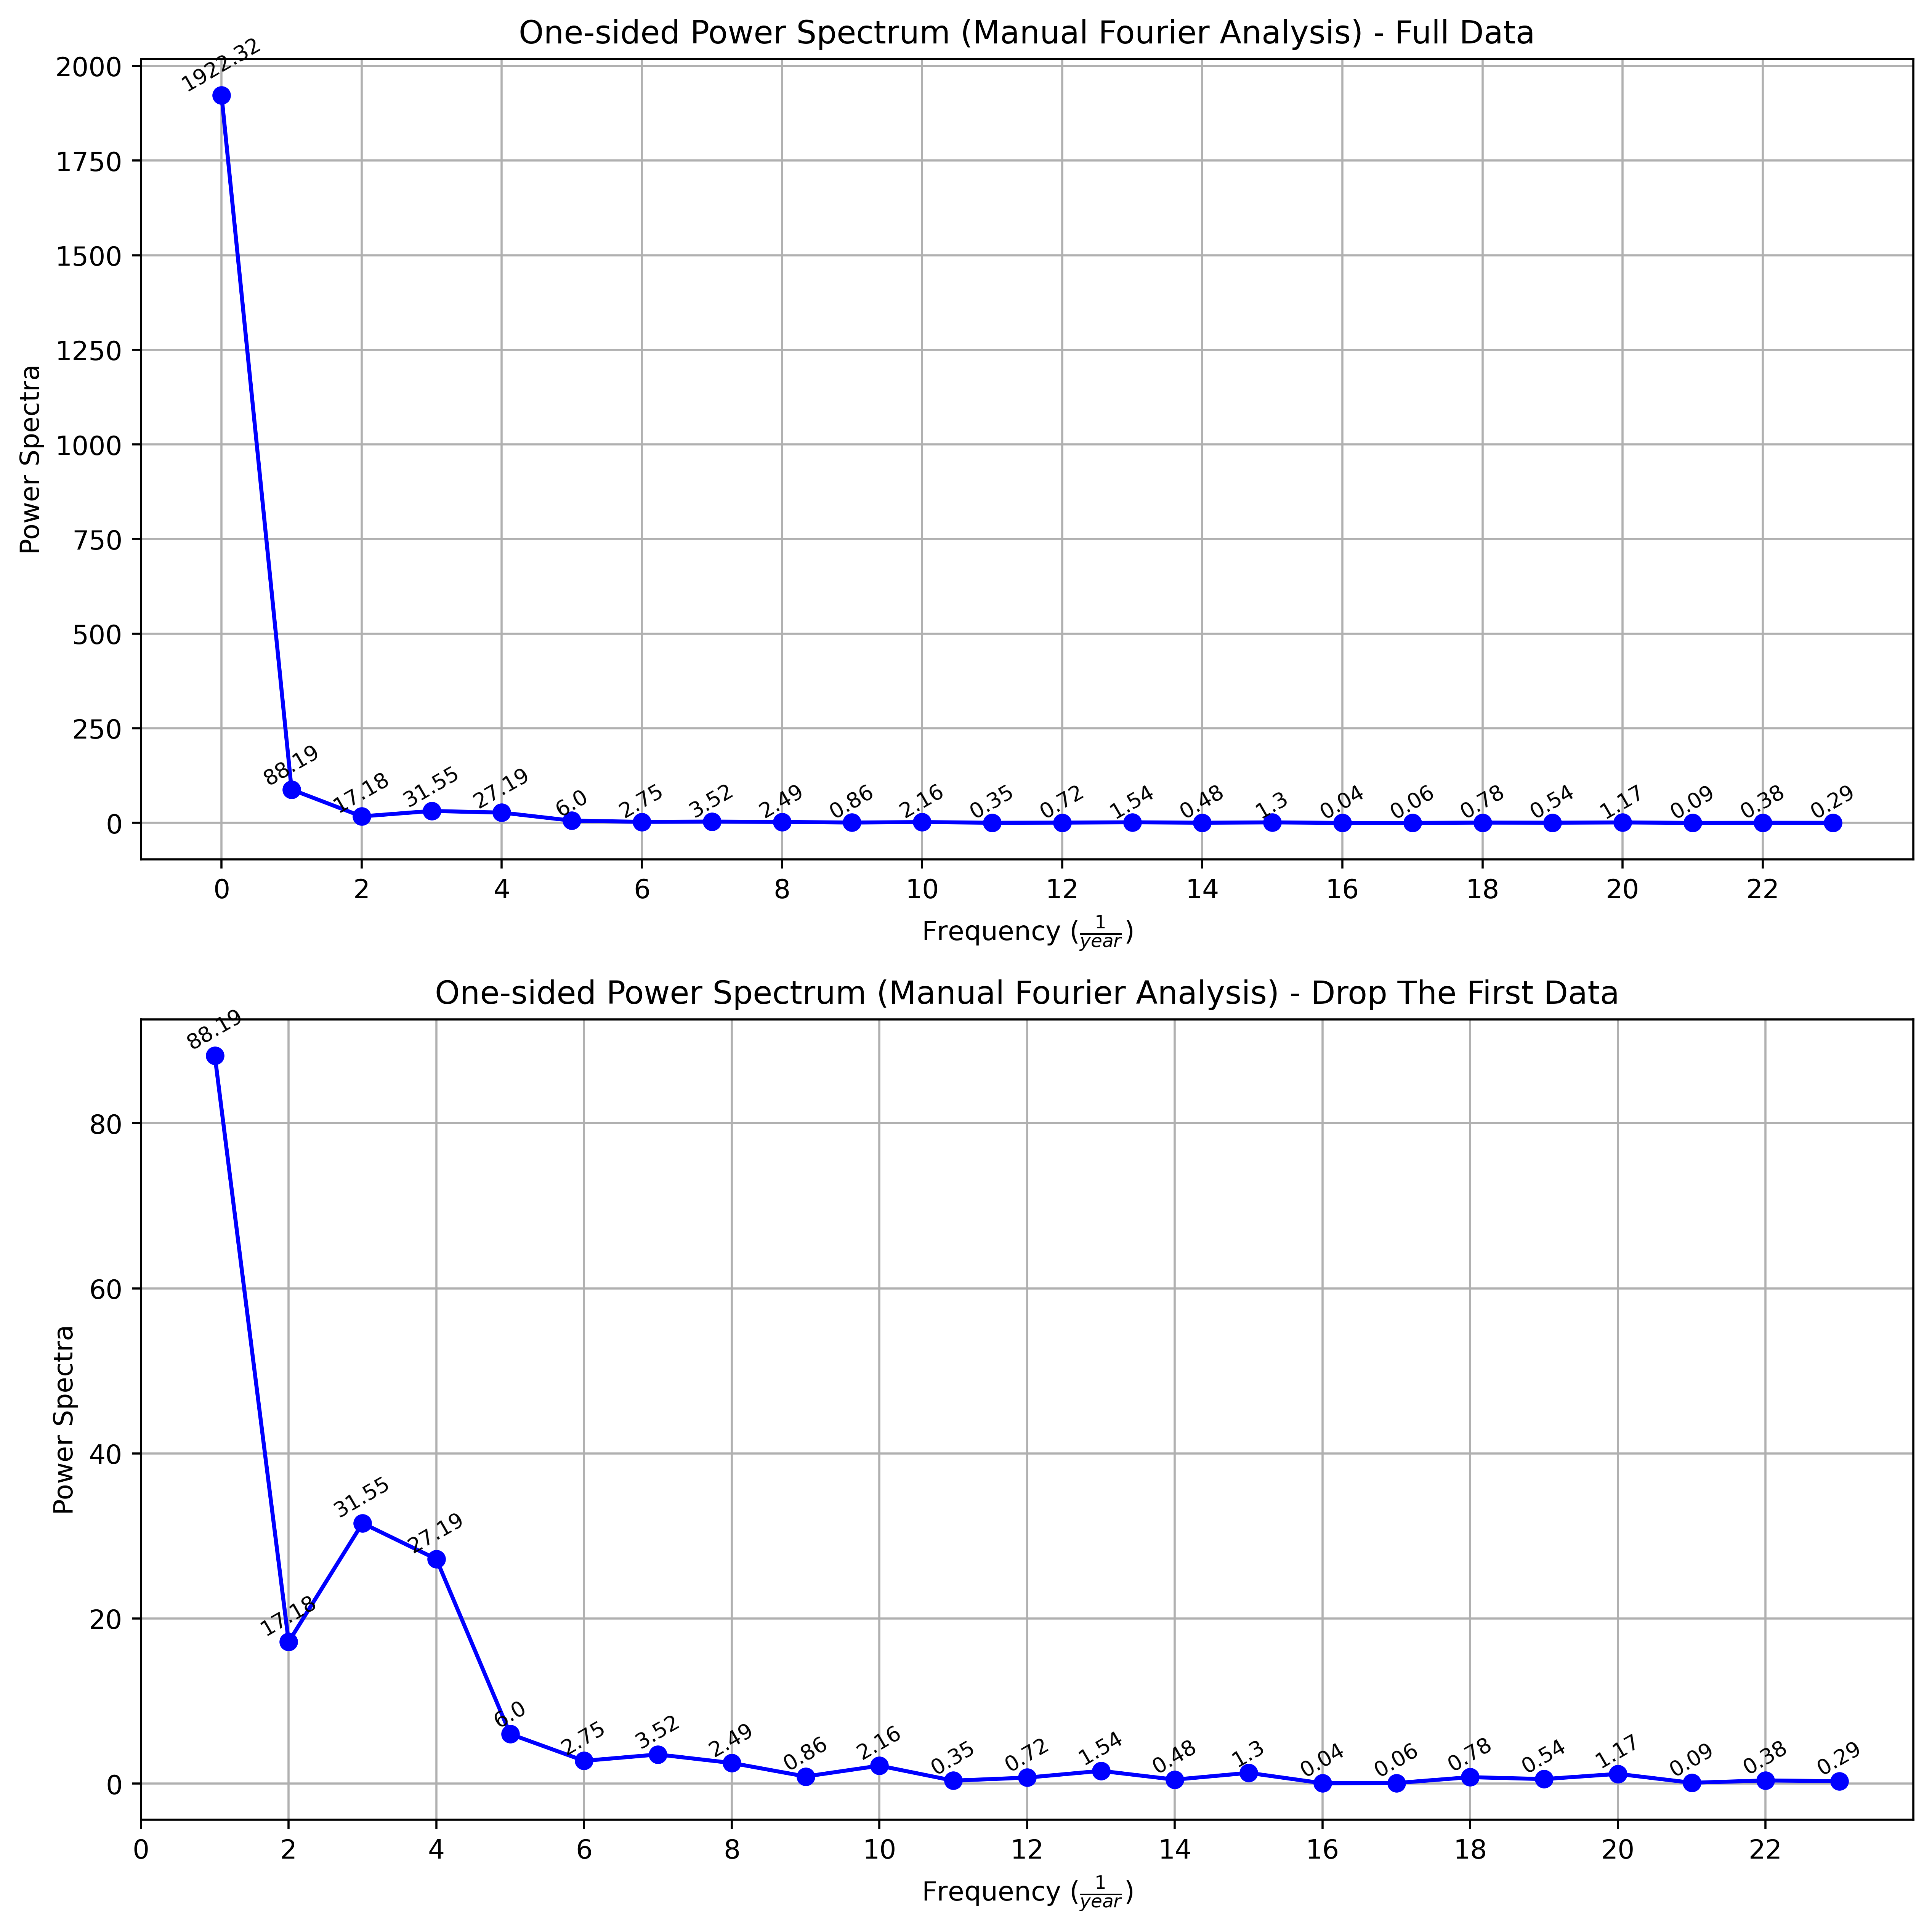

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Your data array
data_array = df.values

# Extract the signal values from the second column
signal_values = data_array[:, 1]

# Perform manual Fourier analysis
N = len(signal_values)
frequencies = np.arange(N) / (data_array[1, 0] - data_array[0, 0])

fourier_result = []

for k in range(N):
    X_k = np.sum(signal_values * np.exp(-1j * 2 * np.pi * k * np.arange(N) / N))
    fourier_result.append(X_k)

# Compute the one-sided power spectrum
power_spectrum = np.abs(fourier_result[:N//2])**2 / N

# Plot the one-sided power spectrum
fig, axs = plt.subplots(2, 1, figsize=(12, 12), dpi=500)
(ax1, ax2) = axs

ax1.plot(frequencies[:len(frequencies)//2], power_spectrum, marker='o', linestyle='-', color='b')
for i, value in enumerate(power_spectrum):
    ax1.text(i, value +0.25, str(round(value,2)), ha='center', va='bottom', rotation=30, fontsize=8)
ax1.set_xlabel(r'Frequency ($\frac{1}{year}$)')
#ax.set_yscale('log')
num_ticks = 20 
step_size = len(frequencies) // num_ticks
ax1.set_xticks(frequencies[:len(frequencies)//2:step_size], rotation=45)  # Adjust rotation as needed
ax1.set_ylabel('Power Spectra')
ax1.set_title('One-sided Power Spectrum (Manual Fourier Analysis) - Full Data')
ax1.grid(True)

ax2.plot(frequencies[1:len(frequencies)//2], power_spectrum[1:], marker='o', linestyle='-', color='b')
for i, value in enumerate(power_spectrum[1:]):
    ax2.text(i+1, value+0.25, str(round(value,2)), ha='center', va='bottom', rotation=30, fontsize=8)
ax2.set_xlabel(r'Frequency ($\frac{1}{year}$)')
#ax.set_yscale('log')
num_ticks = 20 
step_size = len(frequencies) // num_ticks
ax2.set_xticks(frequencies[:len(frequencies)//2:step_size], rotation=45)  # Adjust rotation as needed
ax2.set_ylabel('Power Spectra')
ax2.set_title('One-sided Power Spectrum (Manual Fourier Analysis) - Drop The First Data')
ax2.set_xlim(0, 24)
ax2.grid(True)
plt.show()


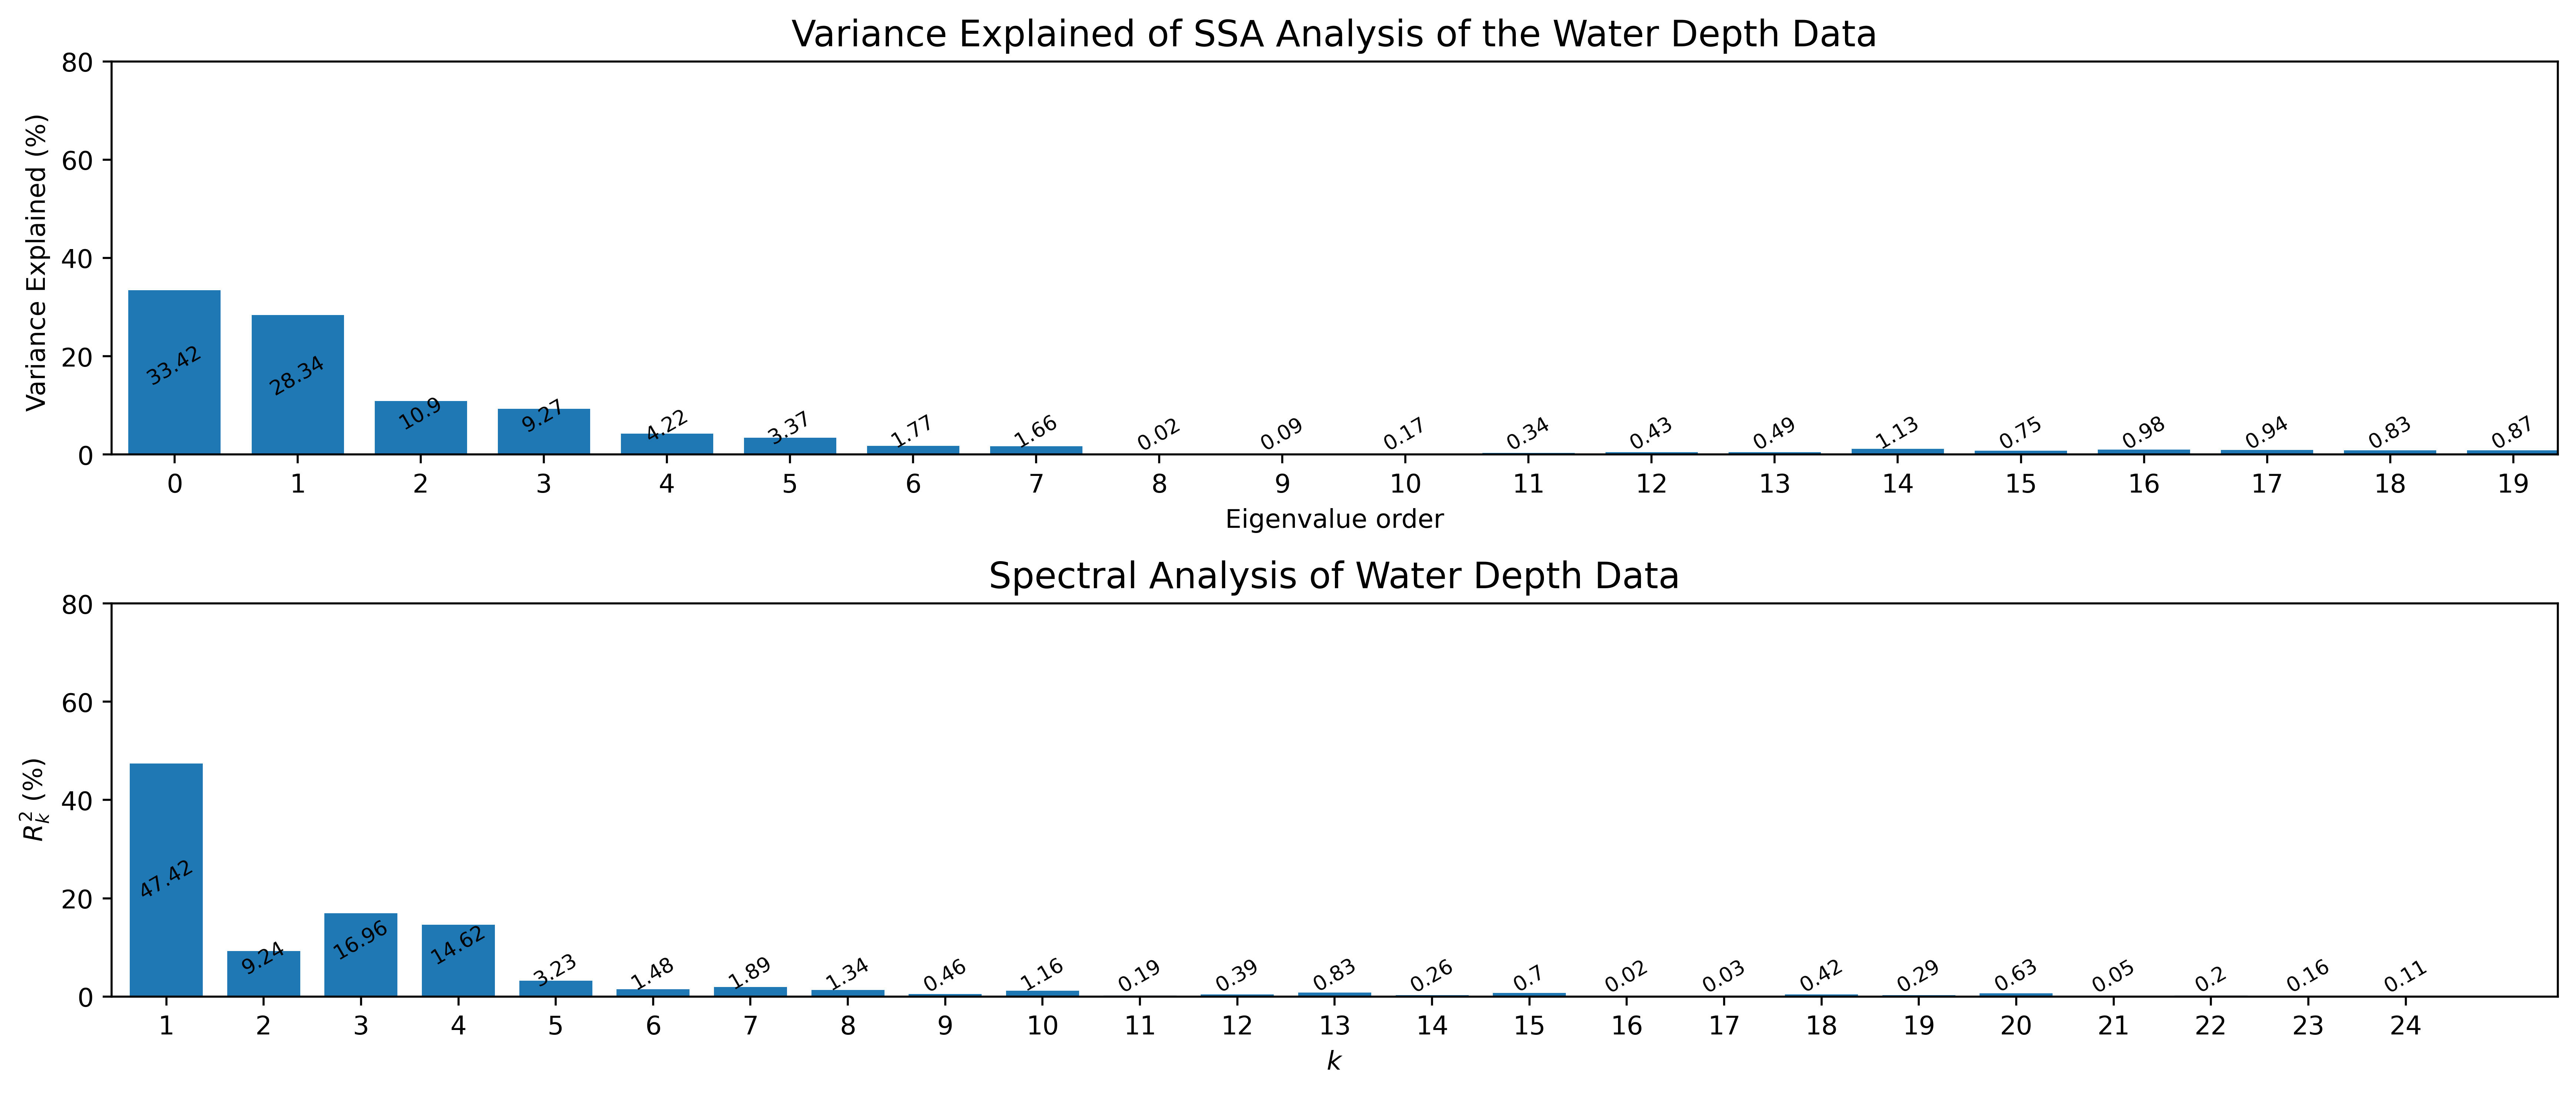

In [17]:
### plot Rk
# calculate Rk
R2 = dff['R2'].values  
totalR2 = np.sum(R2)
#print(totalR2)

k = np.arange(1, ((n-1)/2)+1)
#print(k)

bar_width = 0.75

fig, axs = plt.subplots(2, 1, figsize=(14, 6), dpi=500)
(ax1, ax2) = axs

var_exp = l/(np.sum(l))*100

### plot eigenvalues for SSA analysis
ax1.bar(range(len(l)), var_exp, width=bar_width)
for i, value in enumerate(var_exp):
    ax1.text(i, value /2.5, str(round(value,2)), ha='center', va='bottom', rotation=30, fontsize=8)
ax1.set_xticks(range(0, len(l)+1));
ax1.set_ylim(0, 80)
start, end = ax1.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 1))
ax1.set_xlim(start+0.85, end-1)
ax1.set_title('Variance Explained of SSA Analysis of the Water Depth Data', fontsize=14)
ax1.set_xlabel('Eigenvalue order')
ax1.set_ylabel('Variance Explained (%) ')

### plot for spectral analysis
ax2.bar(k, R2*100,  width=bar_width)
for i, value in enumerate(R2*100):
    ax2.text(i+1, value /2.5, str(round(value,2)), ha='center', va='bottom', rotation=30, fontsize=8)
ax2.set_xticks(range(0, len(k)+1));
ax2.set_ylim(0, 80)
start, end = ax2.get_xlim()
ax2.set_xlim(start+1, end)
ax.xaxis.set_ticks(np.arange(start, end, 1))
ax2.set_title('Spectral Analysis of Water Depth Data', fontsize=14)
ax2.set_xlabel('$k$')
ax2.set_ylabel('$R^{2}_{k}$ (%)')

fig.tight_layout()

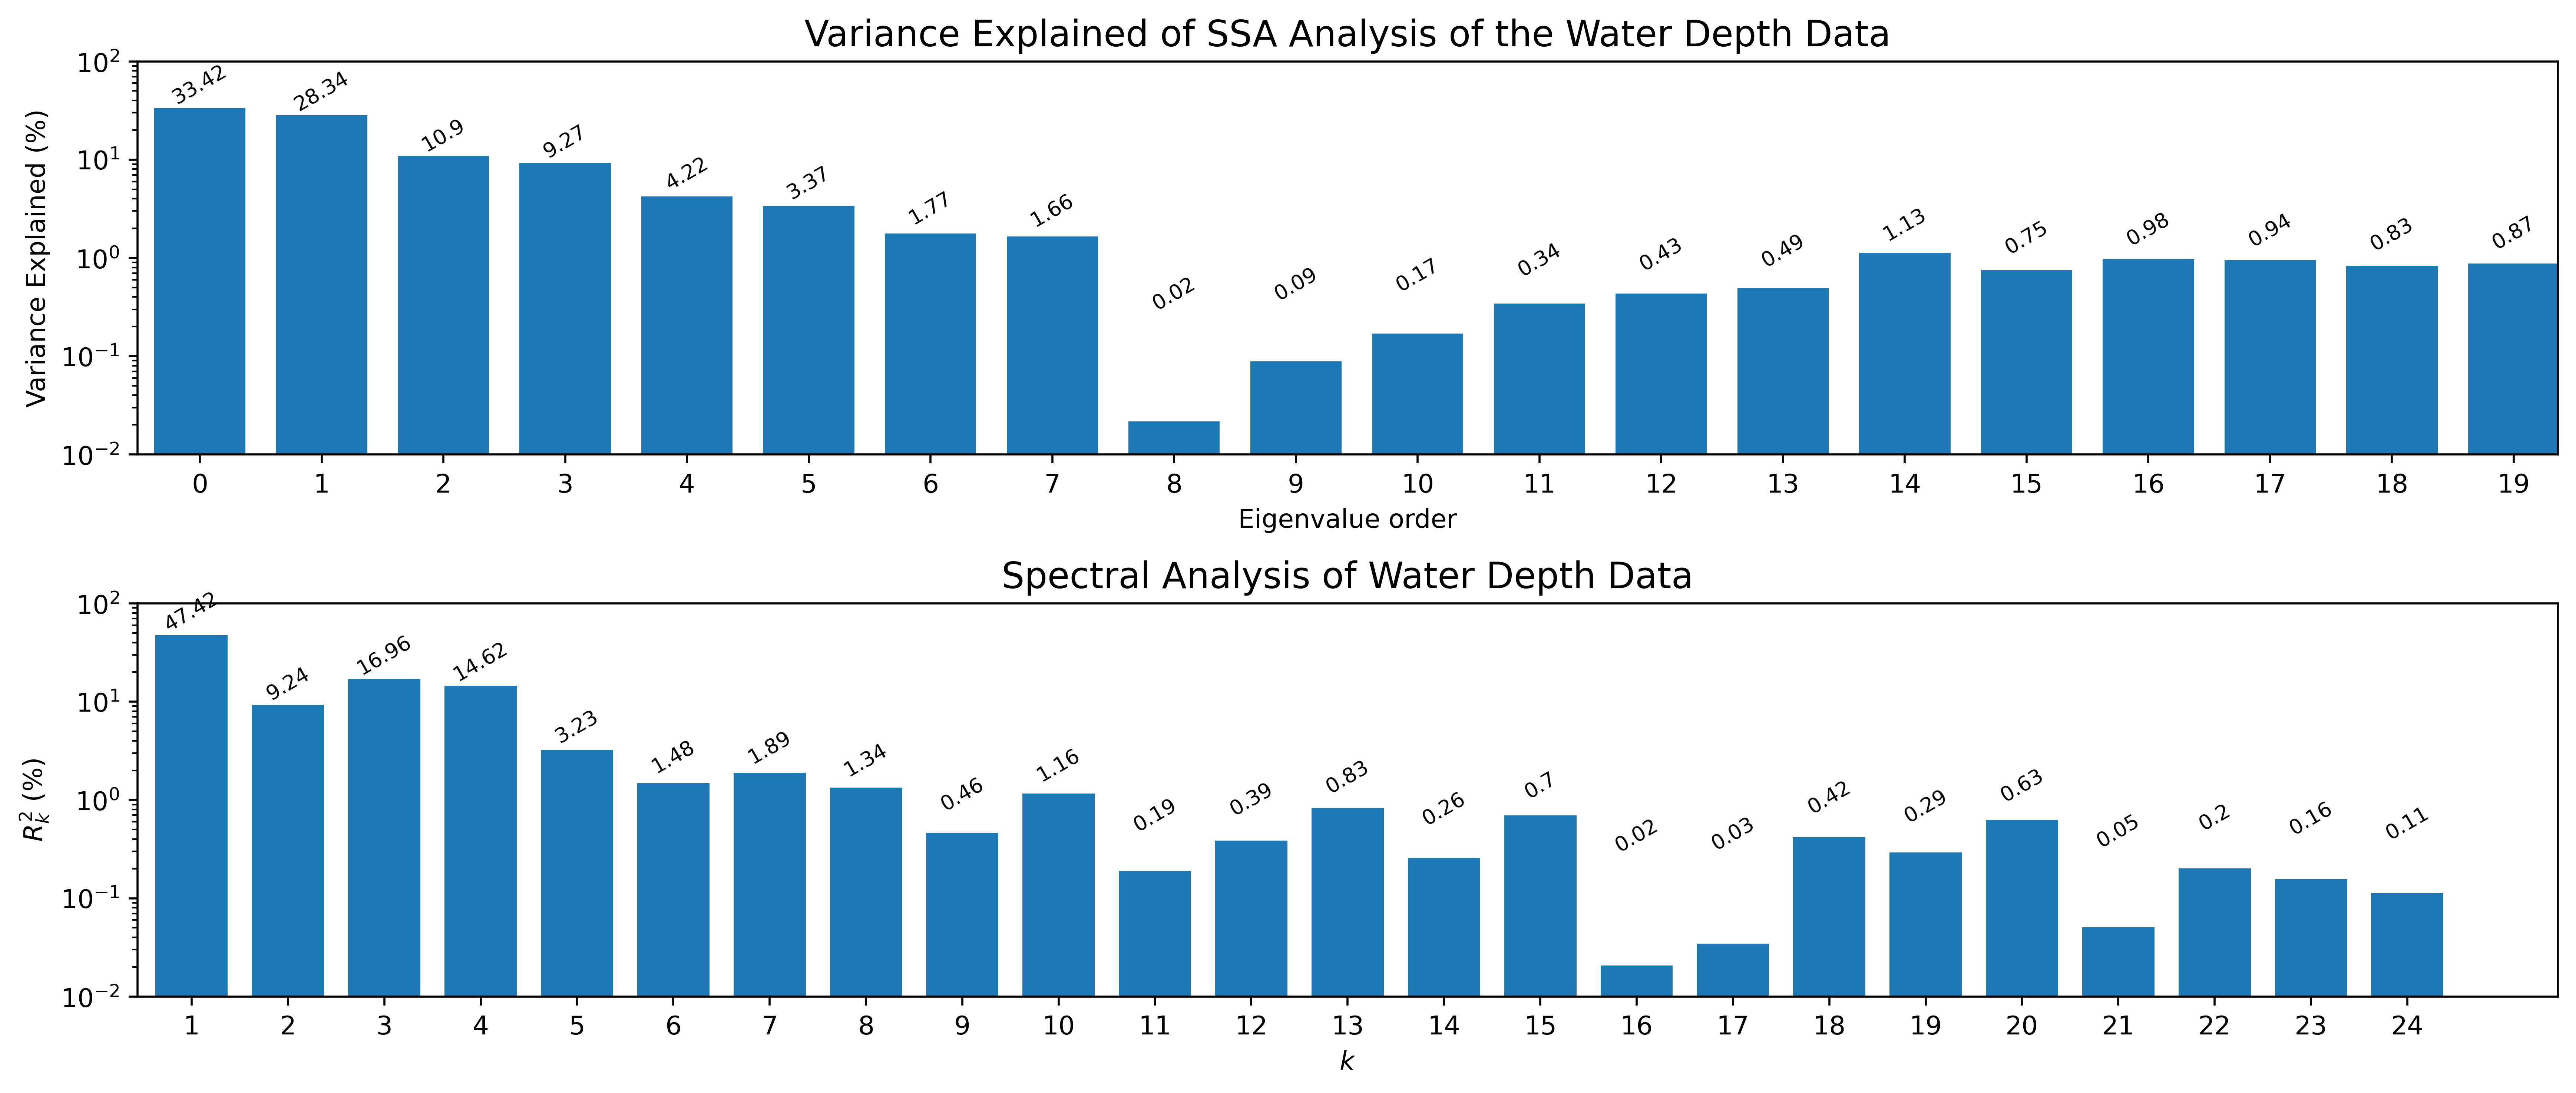

In [18]:
### plot Rk
# calculate Rk
R2 = dff['R2'].values  
totalR2 = np.sum(R2)
#print(totalR2)

#k = np.arange(1, ((n-1)/2)+1)
k = np.arange(1, ((n-1)/2)+1)
#print(k)

bar_width = 0.75

fig, axs = plt.subplots(2, 1, figsize=(14, 6), dpi=500)
(ax1, ax2) = axs

### plot eigenvalues for SSA analysis
var_exp = l/(np.sum(l))*100

ax1.bar(range(len(l)), var_exp, width=bar_width)
for i, value in enumerate(var_exp):
    ax1.text(i, value +0.25, str(round(value,2)), ha='center', va='bottom', rotation=30, fontsize=8)
ax1.set_xticks(range(0, len(l)+1));
ax1.set_yscale('log')
ax1.set_ylim(0.01, 100)
start, end = ax1.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 1))
ax1.set_xlim(start+0.85, end-1)
ax1.set_title('Variance Explained of SSA Analysis of the Water Depth Data', fontsize=14)
ax1.set_xlabel('Eigenvalue order')
ax1.set_ylabel('Variance Explained (%)')

### plot for spectral analysis
ax2.bar(k, R2*100,  width=bar_width)
for i, value in enumerate(R2*100):
    ax2.text(i+1, value +0.25, str(round(value,2)), ha='center', va='bottom', rotation=30, fontsize=8)
ax2.set_xticks(range(0, len(k)+1));
ax2.set_yscale('log')
ax2.set_ylim(0.01, 100)
start, end = ax2.get_xlim()
ax2.set_xlim(start+1, end)
ax.xaxis.set_ticks(np.arange(start, end, 1))
ax2.set_title('Spectral Analysis of Water Depth Data', fontsize=14)
ax2.set_xlabel('$k$')
ax2.set_ylabel('$R^{2}_{k}$ (%)')

fig.tight_layout()